In [1]:
import math
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression,LinearRegression,BayesianRidge, Lasso
from statistics import mean
from math import sqrt



import gc
import datetime
import warnings
from tqdm import tqdm
from pathlib import Path
import time
from copy import deepcopy
import os
import m5forecasting as m5

**First three functions are used to read the data into the Jupyter notebook. Simply use cell 6 in order to read the data in. Use the nrows argument in order to control how much of the data you read into memory (note that the higher the value of nrows, the less data you are reading)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [3]:
def read_data():
    calendar = pd.read_csv('calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv('sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv('sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv('sample_submission.csv')
    return calendar, sell_prices, sales_train_validation, submission

In [4]:
def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # melt sales data, get it ready for training
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    # seperate test dataframes
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # change column names
    test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                      'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # get product table
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test2['id'] = test2['id'].str.replace('_evaluation','_validation')
    test1 = test1.merge(product, how = 'left', on = 'id')
    test2 = test2.merge(product, how = 'left', on = 'id')
    test2['id'] = test2['id'].str.replace('_validation','_evaluation')
    
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis = 0)
    
    del sales_train_validation, test1, test2
    
    data = data.loc[nrows:]
    
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    
    # delete test2 for now, don't delete when we do next stage of testing in June 
    data = data[data['part'] != 'test2']
    
    if merge:
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day'], inplace = True, axis = 1)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass

    
    return data

In [5]:
import pandas as pd
pd.options.mode.chained_assignment = None 

calendar, sell_prices, sales_train_validation, submission = read_data()

data = melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 35000000, merge = True)

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to 3226.27 Mb (9.4% reduction)
Our final dataset to train has 24181090 rows and 18 columns


**Use the function below to control what the start date of the data is (format the start_date argument as a string)

In [6]:
import datetime
def truncate(data, start_date):
    data["date"] = pd.to_datetime(data["date"])

    mask = (data['date'] > start_date)
    data = data.loc[mask]
    data.head()
    
    return data

In [7]:
del calendar, sell_prices, sales_train_validation, submission
gc.collect()

68

**Can use the cell below to get an EDA of a WRMSSE breakdown of a submission (haven't used this before though and we probably don't need it since you already made one)

In [72]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import gc

from sklearn import preprocessing
import lightgbm as lgb

from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm

class WRMSSEEvaluator_dashboard(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
                               .columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 

    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)
    

    
def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') \
                      else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(evaluator, by_level_only=False, model_name=None):
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='', ylabel='WRMSSE')
    
    #######################ALTERATION##########################
    title = 'WRMSSE by Level'
    if model_name: 
        title = f'WRMSSE by Level for {model_name}'
    plt.title(title, fontsize=20, fontweight='bold')
    #######################ALTERATION-COMPLETE##########################

  
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
        
    #######################ALTERATION##########################
    if by_level_only:       # stops function early for quick plotting of 
        plt.show()          # for quick plotting of levels
        return
    #######################ALTERATION-COMPLETE##########################

    # configuration array for the charts
    n_rows = [1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]
    n_cols = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    width = [7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
    height = [4, 3, 12, 3, 9, 9, 9, 9, 9, 9, 9, 9]
    
    for i in range(1,13):
        
        scores = getattr(evaluator, f'lv{i}_scores')
        weights = getattr(evaluator, f'lv{i}_weight')
        
        if i > 1 and i < 9:
            if i < 7:
                fig, axs = plt.subplots(1, 2, figsize=(12, 3))
            else:
                fig, axs = plt.subplots(2, 1, figsize=(12, 8))
                
            ## RMSSE plot
            scores.plot.bar(width=.8, ax=axs[0], color='g')
            axs[0].set_title(f"RMSSE", size=14)
            axs[0].set(xlabel='', ylabel='RMSSE')
            if i >= 4:
                axs[0].tick_params(labelsize=8)
            for index, val in enumerate(scores):
                axs[0].text(index*1, val+.01, round(val,4), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
            
            ## Weight plot
            weights.plot.bar(width=.8, ax=axs[1])
            axs[1].set_title(f"Weight", size=14)
            axs[1].set(xlabel='', ylabel='Weight')
            if i >= 4:
                axs[1].tick_params(labelsize=8)
            for index, val in enumerate(weights):
                axs[1].text(index*1, val+.01, round(val,2), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
                    
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 ,
                         y=1.1, fontweight='bold')
            plt.tight_layout()
            plt.show()

        trn = create_viz_df(getattr(evaluator, f'lv{i}_train_df')\
                            .iloc[:, -28*3:], i)
        val = create_viz_df(getattr(evaluator, f'lv{i}_valid_df'), i)
        pred = create_viz_df(getattr(evaluator, f'lv{i}_valid_preds'), i)

        n_cate = trn.shape[1] if i < 7 else 9

        fig, axs = plt.subplots(n_rows[i-1], n_cols[i-1], 
                                figsize=(width[i-1],height[i-1]))
        if i > 1:
            axs = axs.flatten()

        ## Time series plot
        for k in range(0, n_cate):

            ax = axs[k] if i > 1 else axs

            trn.iloc[:, k].plot(ax=ax, label='train')
            val.iloc[:, k].plot(ax=ax, label='valid')
            pred.iloc[:, k].plot(ax=ax, label='pred')
            ax.set_title(f"{trn.columns[k]}  RMSSE:{scores[k]:.4f}", size=14)
            ax.set(xlabel='', ylabel='sales')
            ax.tick_params(labelsize=8)
            ax.legend(loc='upper left', prop={'size': 10})

        if i == 1 or i >= 9:
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 , 
                         y=1.1, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
train_df = pd.read_csv('sales_train_evaluation.csv')
calendar_df = pd.read_csv('calendar.csv')
sell_prices_df = pd.read_csv('sell_prices.csv')

train_fold_df = train_df.iloc[:, :-28]
valid_fold_df = train_fold_df.iloc[:, -28:].copy()
# Instantiate an evaluator for scoring validation periodstarting day 1886
e = WRMSSEEvaluator_dashboard(train_fold_df, valid_fold_df, calendar_df, sell_prices_df)


**Ignore all stuff until the next markdown cell (was just trying to make a WRMSSE metric before I found the evaluator class)

In [13]:
cols = ["d_{}".format(i) for i in range(1914-28, 1914)]
lastdata = sales_train_validation[["id", 'store_id', 'item_id'] + cols]

lastdata = lastdata.melt(id_vars=["id", 'store_id', 'item_id'], 
                 var_name="d", value_name="sale")

lastdata = pd.merge(lastdata, calendar, how = 'left', 
                left_on = ['d'], right_on = ['d'])

lastdata = lastdata[["id", 'store_id', 'item_id', "sale", "d", "wm_yr_wk"]]

lastdata = lastdata.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
lastdata.drop(columns = ['wm_yr_wk'], inplace=True)

lastdata['sale_usd'] = lastdata['sale'] * lastdata['sell_price']
lastdata.head()





,id,store_id,item_id,sale,d,sell_price,sale_usd
0,HOBBIES_1_001_CA_1_validation,CA_1,HOBBIES_1_001,1,d_1886,8.257812,8.257812
1,HOBBIES_1_002_CA_1_validation,CA_1,HOBBIES_1_002,1,d_1886,3.970703,3.970703
2,HOBBIES_1_003_CA_1_validation,CA_1,HOBBIES_1_003,0,d_1886,2.970703,0.000000
3,HOBBIES_1_004_CA_1_validation,CA_1,HOBBIES_1_004,0,d_1886,4.640625,0.000000
4,HOBBIES_1_005_CA_1_validation,CA_1,HOBBIES_1_005,1,d_1886,2.880859,2.880859


In [14]:
sales = sales_train_validation

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
import gc

In [16]:
dummies_list = [sales.state_id, sales.store_id, 
                sales.cat_id, sales.dept_id, 
                sales.state_id +'_'+ sales.cat_id, sales.state_id +'_'+ sales.dept_id,
                sales.store_id +'_'+ sales.cat_id, sales.store_id +'_'+ sales.dept_id, 
                sales.item_id, sales.state_id +'_'+ sales.item_id, sales.id]


dummies_df_list =[pd.DataFrame(np.ones(sales.shape[0]).astype(np.int8), 
                               index=sales.index, columns=['all']).T]

for i, cats in enumerate(dummies_list):
    dummies_df_list +=[pd.get_dummies(cats, drop_first=False, dtype=np.int8).T]
    
roll_mat_df = pd.concat(dummies_df_list, keys=list(range(12)), 
                        names=['level','id'])#.astype(np.int8, copy=False)

roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)
roll_mat_csr.shape

(42840, 30490)

In [17]:
roll_mat_df.to_pickle('roll_mat_df.pkl')
del dummies_df_list, roll_mat_df, sales_train_validation, calendar, sell_prices
gc.collect()

20

In [18]:
def get_s(drop_days=0):
    d_name = ['d_' + str(i+1) for i in range(1913-drop_days)]
    sales_train_val = roll_mat_csr * sales[d_name].values

    no_sales = np.cumsum(sales_train_val, axis=1) == 0
    sales_train_val = np.where(no_sales, np.nan, sales_train_val)

    weight1 = np.nanmean(np.diff(sales_train_val,axis=1)**2,axis=1)
    
    return weight1

In [19]:
S = get_s(drop_days=0)
S.shape

(42840,)

In [20]:
def get_w(sale_usd):

    total_sales_usd = sale_usd.groupby(
        ['id'], sort=False)['sale_usd'].apply(np.sum).values
    weight2 = roll_mat_csr * total_sales_usd

    return 12*weight2/np.sum(weight2)

In [21]:
W = get_w(lastdata[['id','sale_usd']])
W.shape

(42840,)

In [23]:
SW = W/np.sqrt(S)
sw_df = pd.DataFrame(np.stack((S, W, SW), axis=-1),index = roll_index,columns=['s','w','sw'])
sw_df.to_pickle('sw_df.pkl')

del W_original_df
gc.collect()

53

In [24]:
def rollup(v):
    return roll_mat_csr*v 

In [25]:
sw_df = pd.read_pickle('sw_df.pkl')
S = sw_df.s.values
W = sw_df.w.values
SW = sw_df.sw.values

roll_mat_df = pd.read_pickle('roll_mat_df.pkl')
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)
del roll_mat_df

In [26]:
del lastdata, sw_df, W_df

gc.collect()

60

In [109]:
def wrmsse_eval(preds, y_true, s = S, w = W, sw = SW):
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(rollup(preds.values-y_true.values))
                            ,axis=1)) * sw)/12 

    return "WRMSSE", score, False

**The transform function simply label encodes the categorical features and add in some additional data features by breaking it down into month, day, year. 

In [8]:
from sklearn.preprocessing import LabelEncoder

def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
        
    data['date'] = pd.to_datetime(data['date'])
    time_features = ['year', 'month', 'quarter', 'week', 'day', 'dayofweek', 'dayofyear']
    dtype = np.int16
    for time_feature in time_features:
        data[time_feature] = getattr(data['date'].dt, time_feature).astype(dtype)
        
    data = reduce_mem_usage(data)
    
    return data

In [9]:
data = transform(data)

Mem. usage decreased to 1383.65 Mb (54.9% reduction)


In [42]:
data.isnull().sum()

id                    0
item_id               0
dept_id               0
cat_id                0
store_id              0
state_id              0
demand                0
part                  0
date                  0
wm_yr_wk              0
event_name_1          0
event_type_1          0
event_name_2          0
event_type_2          0
snap_CA               0
snap_TX               0
snap_WI               0
sell_price       591425
year                  0
month                 0
quarter               0
week                  0
day                   0
dayofweek             0
dayofyear             0
imputed_price    591425
combined              0
scaled_weight         0
dtype: int64

**This is the function that generates the features. All of the comemnted stuff are things I think we should try. The features I commented out were just bad features but I think the weighted average will be good once implemented correctly 

In [6]:
#add in event proximity at some point, see if it gives good results in conjunction with other features
#add in feature to capture state-specific SNAP dates - namely SNAP occurs in first half of month 
#maybe add in a low vs high price feature - notice that FOOD3 is particularly low priced
#there is a state by state variation in how different event types affect sales 
#price lag? we already have price momentum 
#add in weather data, that definitely influnces sales 
#add in features that captures ARIMA stuff - like auto-correlation, integration, moving average -
#or just run ARIMA model in emsembles 
#capture population change in each state 
#math transformations 
#how are we addressing out of stock values
#weekend vs not weekend
#week momentum instead of daily

from datetime import date, datetime


def new_features(data):
    
    data_fe = data[['id', 'demand']]
    
    window = 28
    periods = [1, 2, 3, 4, 5, 6, 7]
    group = data_fe.groupby('id')['demand']
    
    # most recent lag data
    for period in periods:
        data_fe['demand_rolling_mean_t' + str(period)] = group.transform(lambda x: x.shift(window).rolling(period).mean())
        data_fe['demand_rolling_std_t' + str(period)] = group.transform(lambda x: x.shift(window).rolling(period).std())
        data_fe['sales_lag_t' + str(period)] = group.transform(lambda x: x.shift(window + period))
    
    
    def get_season(date):
        year = str(date.year)
        seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
                   'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
                   'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
        if date in seasons['spring']:
            return 0
        if date in seasons['summer']:
            return 1
        if date in seasons['autumn']:
            return 2
        else:
            return 3
        
    data_fe['season'] = data['date'].map(get_season)
    
    #data_fe['price_max'] = data.groupby('id')['sell_price'].transform('max')
    #data_fe['price_min'] = data.groupby('id')['sell_price'].transform('min')
    #data_fe['price_std'] = data.groupby('id')['sell_price'].transform('std')
    #data_fe['price_mean'] = data.groupby('id')['sell_price'].transform('mean')  
    
    #data_fe['price_norm'] = data['sell_price']/data_fe['price_max']
    #data_fe['price_nunique'] = data.groupby('id')['sell_price'].transform('nunique')
    
    #data_fe['price_momentum'] = data['sell_price']/data.groupby('id')['sell_price'].transform(lambda x: x.shift(1))
    #data_fe['price_momentum_m'] = data['sell_price']/data.groupby(['id', 'month'])['sell_price'].transform('mean')
    #data_fe['price_momentum_y'] = data['sell_price']/data.groupby(['id', 'year'])['sell_price'].transform('mean')
    
    #data_fe['sale_momentum_m'] = data['demand']/data.groupby(['id','month'])['demand'].transform('mean')
    #data_fe['sale_momentum_y'] = data['demand']/data.groupby(['id','year'])['demand'].transform('mean')
    
    temp = data_fe

    temp.set_index(data['date'])
    weighted_periods = [1, 2, 3, 4, 5, 6, 7]
    weighted_group = temp.groupby('id')['demand']
    
    #for weight in weighted_periods:
        #data_fe['weighted_sales_t' + str(weight)] = weighted_group.transform(lambda x: x.ewm(span = weight + 28).mean())
    
    
    data_fe = reduce_mem_usage(data_fe)
        
    lag_rolling_features = [col for col in data_fe.columns if col not in ['id', 'demand']]
    data = pd.concat([data, data_fe[lag_rolling_features]], axis = 1)
    
    del data_fe, temp

    return data

In [15]:
gc.collect()

20

In [11]:
def impute_price(data):
    data['imputed_price'] = data['sell_price'].fillna(method = 'ffill')
    return data

In [12]:
data['sell_price'] = data['sell_price'].astype('float32')

gc.collect()

40

In [13]:
data = impute_price(data)

In [10]:
data = truncate(data, '2014-04-01')

In [54]:
data['imputed_price'] = data['sell_price']

rows = data[data.sell_price.isnull()].index
print(rows)

Int64Index([   34408,    34409,    34410,    34411,    34412,    34413,
               34414,    34415,    34416,    34417,
            ...
            23831513, 23831514, 23831515, 23831516, 23831517, 23831518,
            23831519, 23831520, 23831521, 23831522],
           dtype='int64', length=591425)


In [53]:
data['imputed_price'].isnull().sum()

591425

In [ ]:
from datetime import date, datetime


def new_features_daily(data):
    
    data_fe = data[['id', 'demand']]
    
    days = [1, 2, 3, 4, 5, 6, 7]
    periods = [7, 28]
    group = data_fe.groupby('id')['demand']
    
    # most recent lag data
    for period in periods:
        for day in days:
            data_fe['demand_rolling_mean_t' + str(day) + "_" + str(period)] = group.transform(lambda x: x.shift(day).rolling(period).mean())
            data_fe['demand_rolling_std_t' + str(day) + "_" + str(period)] = group.transform(lambda x: x.shift(day).rolling(period).std())
            data_fe['sales_lag_t' + str(day)] = group.transform(lambda x: x.shift(day))

    
    def get_season(date):
        year = str(date.year)
        seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
                   'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
                   'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
        if date in seasons['spring']:
            return 0
        if date in seasons['summer']:
            return 1
        if date in seasons['autumn']:
            return 2
        else:
            return 3
        
    data_fe['season'] = data['date'].map(get_season)
    
    #data_fe['price_max'] = data.groupby('id')['sell_price'].transform('max')
    #data_fe['price_min'] = data.groupby('id')['sell_price'].transform('min')
    #data_fe['price_std'] = data.groupby('id')['sell_price'].transform('std')
    #data_fe['price_mean'] = data.groupby('id')['sell_price'].transform('mean')  
    
    #data_fe['price_norm'] = data['sell_price']/data_fe['price_max']
    #data_fe['price_nunique'] = data.groupby('id')['sell_price'].transform('nunique')
    
    #data_fe['price_momentum'] = data['sell_price']/data.groupby('id')['sell_price'].transform(lambda x: x.shift(1))
    #data_fe['price_momentum_m'] = data['sell_price']/data.groupby(['id', 'month'])['sell_price'].transform('mean')
    #data_fe['price_momentum_y'] = data['sell_price']/data.groupby(['id', 'year'])['sell_price'].transform('mean')
    
    #data_fe['sale_momentum_m'] = data['demand']/data.groupby(['id','month'])['demand'].transform('mean')
    #data_fe['sale_momentum_y'] = data['demand']/data.groupby(['id','year'])['demand'].transform('mean')
    
    #temp = data_fe

    #temp.set_index(data['date'])
    #weighted_periods = [1, 2, 3, 4, 5, 6, 7]
    #weighted_group = temp.groupby('id')['demand']
    
    #for weight in weighted_periods:
        #data_fe['weighted_sales_t' + str(weight)] = weighted_group.transform(lambda x: x.ewm(span = weight + 28).mean())
    
    
    data_fe = reduce_mem_usage(data_fe)
        
    lag_rolling_features = [col for col in data_fe.columns if col not in ['id', 'demand']]
    data = pd.concat([data, data_fe[lag_rolling_features]], axis = 1)
    
    del data_fe
    gc.collect()
    return data


In [ ]:
from datetime import date, datetime


def new_features_weekly(data):
    
    data_fe = data[['id', 'demand']]
    
    days = [1, 2, 3, 4, 5, 6, 7]
    periods = [7, 28]
    group = data_fe.groupby('id')['demand']
    
    # most recent lag data
    for period in periods:
        for day in days:
            data_fe['demand_rolling_mean_t' + str(day) + "_" + str(period)] = group.transform(lambda x: x.shift(day).rolling(period).mean())
            data_fe['demand_rolling_std_t' + str(day) + "_" + str(period)] = group.transform(lambda x: x.shift(day).rolling(period).std())
            data_fe['sales_lag_t' + str(day)] = group.transform(lambda x: x.shift(day))

    
    def get_season(date):
        year = str(date.year)
        seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
                   'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
                   'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
        if date in seasons['spring']:
            return 0
        if date in seasons['summer']:
            return 1
        if date in seasons['autumn']:
            return 2
        else:
            return 3
        
    data_fe['season'] = data['date'].map(get_season)
    
    #data_fe['price_max'] = data.groupby('id')['sell_price'].transform('max')
    #data_fe['price_min'] = data.groupby('id')['sell_price'].transform('min')
    #data_fe['price_std'] = data.groupby('id')['sell_price'].transform('std')
    #data_fe['price_mean'] = data.groupby('id')['sell_price'].transform('mean')  
    
    #data_fe['price_norm'] = data['sell_price']/data_fe['price_max']
    #data_fe['price_nunique'] = data.groupby('id')['sell_price'].transform('nunique')
    
    #data_fe['price_momentum'] = data['sell_price']/data.groupby('id')['sell_price'].transform(lambda x: x.shift(1))
    #data_fe['price_momentum_m'] = data['sell_price']/data.groupby(['id', 'month'])['sell_price'].transform('mean')
    #data_fe['price_momentum_y'] = data['sell_price']/data.groupby(['id', 'year'])['sell_price'].transform('mean')
    
    #data_fe['sale_momentum_m'] = data['demand']/data.groupby(['id','month'])['demand'].transform('mean')
    #data_fe['sale_momentum_y'] = data['demand']/data.groupby(['id','year'])['demand'].transform('mean')
    
    #temp = data_fe

    #temp.set_index(data['date'])
    #weighted_periods = [1, 2, 3, 4, 5, 6, 7]
    #weighted_group = temp.groupby('id')['demand']
    
    #for weight in weighted_periods:
        #data_fe['weighted_sales_t' + str(weight)] = weighted_group.transform(lambda x: x.ewm(span = weight + 28).mean())
    
    
    data_fe = reduce_mem_usage(data_fe)
        
    lag_rolling_features = [col for col in data_fe.columns if col not in ['id', 'demand']]
    data = pd.concat([data, data_fe[lag_rolling_features]], axis = 1)
    
    del data_fe
    gc.collect()
    return data


**Ignore the stuff until the next markdown cell. Just my attempts from earlier to create custom loss

In [14]:
def tweedie_eval(y_pred, y_true, p=1.5):
    y_true = y_true.get_label()
    a = y_true*np.exp(y_pred, (1-p)) / (1-p)
    b = np.exp(y_pred, (2-p))/(2-p)
    loss = -a + b
    return loss 

In [36]:
del rect, rec
gc.collect()

90

In [16]:
#tr_w = tr_x[ID_COLS]

In [38]:
for col in data.columns:
    print(col)

index
id
item_id
dept_id
cat_id
store_id
state_id
demand
part
date
wm_yr_wk
event_name_1
event_type_1
event_name_2
event_type_2
snap_CA
snap_TX
snap_WI
sell_price
gaps
gap_confirm
out_of_stock
true
imputed_demand
year
month
quarter
week
day
dayofweek
dayofyear
lag_28
lag_29
lag_35
lag_42
lag_56
shift_1_rolling_mean_7
shift_1_rolling_std_7
shift_1_rolling_mean_14
shift_1_rolling_std_14
shift_1_rolling_mean_28
shift_1_rolling_std_28
shift_28_rolling_mean_7
shift_28_rolling_mean_14
shift_28_rolling_mean_28
combined
scaled_weight
shift_28_rolling_std_7
shift_28_rolling_std_14
shift_28_rolling_std_28


In [42]:
ID_COLS = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

tr_x = data[data['date']<='2016-03-27']
tr_w = tr_x[ID_COLS]

In [53]:
level = wdf[wdf.Level_id == 'Level2']
encoder = LabelEncoder()
level['state_id'] = encoder.fit_transform(level['state_id'])
level.head()

,Level_id,Agg_Level_1,Agg_Level_2,scaled_weight
1,Level2,CA,X,0.000163
2,Level2,TX,X,0.000147
3,Level2,WI,X,0.000149


In [54]:
wdf.head()

,Level_id,Agg_Level_1,Agg_Level_2,scaled_weight
0,Level1,Total,X,0.000169
1,Level2,CA,X,0.000163
2,Level2,TX,X,0.000147
3,Level2,WI,X,0.000149
4,Level3,CA_1,X,0.000128


In [56]:
encoder = LabelEncoder()
wdf = pd.read_csv('weight_scale_1914.csv')
wdf['scaled_weight'] = wdf.weight/np.sqrt(wdf.scale)
wdf = wdf[[ 'Level_id', 'Agg_Level_1', 'Agg_Level_2','scaled_weight']]


######################### level 1 #######################################
tr_w['level_1_sw'] = wdf.loc[wdf['Level_id'] == 'Level1', 'scaled_weight'][0]

######################### level 2 #######################################
level = wdf[wdf.Level_id == 'Level2']
# Set the name of the aggregation column to match 
# the column in our id columns
level.columns = ['Level_id', 'state_id', 'Agg_Level_2', 'scaled_weight']
level['state_id'] = encoder.fit_transform(level['state_id'])
level_scaled_weight = pd.merge(tr_w[['state_id']], level[['state_id', 'scaled_weight']],
                               on='state_id', how='left')[['scaled_weight']]
tr_w['level_2_sw'] = level_scaled_weight['scaled_weight'].values

del level, level_scaled_weight

######################### level 3 #######################################
level = wdf[wdf.Level_id == 'Level3']
# Set the name of the aggregation column to match 
# the column in our id columns
level.columns = ['Level_id', 'store_id', 'Agg_Level_2', 'scaled_weight']
level['store_id'] = encoder.fit_transform(level['store_id'])
level_scaled_weight = pd.merge(tr_w[['store_id']], level[['store_id', 'scaled_weight']],
                               on='store_id', how='left')[['scaled_weight']]
tr_w['level_3_sw'] = level_scaled_weight['scaled_weight'].values

del level, level_scaled_weight

######################### level 4 #######################################
level = wdf[wdf.Level_id == 'Level4']
# Set the name of the aggregation column to match 
# the column in our id columns
level.columns = ['Level_id', 'cat_id', 'Agg_Level_2', 'scaled_weight']
level['cat_id'] = encoder.fit_transform(level['cat_id'])
level_scaled_weight = pd.merge(tr_w[['cat_id']], level[['cat_id', 'scaled_weight']],
                               on='cat_id', how='left')[['scaled_weight']]
tr_w['level_4_sw'] = level_scaled_weight['scaled_weight'].values

del level, level_scaled_weight

######################### level 5 #######################################
level = wdf[wdf.Level_id == 'Level5']
# Set the name of the aggregation column to match 
# the column in our id columns
level.columns = ['Level_id', 'dept_id', 'Agg_Level_2', 'scaled_weight']
level['dept_id'] = encoder.fit_transform(level['dept_id'])
level_scaled_weight = pd.merge(tr_w[['dept_id']], level[['dept_id', 'scaled_weight']],
                               on='dept_id', how='left')[['scaled_weight']]
                                        
tr_w['level_5_sw'] = level_scaled_weight['scaled_weight'].values

del level, level_scaled_weight

######################### level 6 #######################################
level = wdf[wdf.Level_id == 'Level6']
# Set the name of the aggregation column to match 
# the column in our id columns
level.columns = ['Level_id', 'state_id', 'cat_id', 'scaled_weight']
level['state_id'] = encoder.fit_transform(level['state_id'])
level['cat_id'] = encoder.fit_transform(level['cat_id'])
level_scaled_weight = pd.merge(tr_w[['state_id', 'cat_id']], level[['state_id', 'cat_id', 'scaled_weight']],
                               on=['state_id', 'cat_id'], how='left')[['scaled_weight']]
tr_w['level_6_sw'] = level_scaled_weight['scaled_weight'].values

del level, level_scaled_weight

######################### level 7 #######################################
level = wdf[wdf.Level_id == 'Level7']
# Set the name of the aggregation column to match 
# the column in our id columns
level.columns = ['Level_id', 'state_id', 'dept_id', 'scaled_weight']
level['state_id'] = encoder.fit_transform(level['state_id'])
level['dept_id'] = encoder.fit_transform(level['dept_id'])
level_scaled_weight = pd.merge(tr_w[['state_id', 'dept_id']], level[['state_id', 'dept_id', 'scaled_weight']],
                               on=['state_id', 'dept_id'], how='left')[['scaled_weight']]
tr_w['level_7_sw'] = level_scaled_weight['scaled_weight'].values

del level, level_scaled_weight

######################### level 8 #######################################
level = wdf[wdf.Level_id == 'Level8']
# Set the name of the aggregation column to match 
# the column in our id columns
level.columns = ['Level_id', 'store_id', 'cat_id', 'scaled_weight']
level['store_id'] = encoder.fit_transform(level['store_id'])
level['cat_id'] = encoder.fit_transform(level['cat_id'])
level_scaled_weight = pd.merge(tr_w[['store_id', 'cat_id']], level[['store_id', 'cat_id', 'scaled_weight']],
                               on=['store_id', 'cat_id'], how='left')[['scaled_weight']]
tr_w['level_8_sw'] = level_scaled_weight['scaled_weight'].values

del level, level_scaled_weight

######################### level 9 #######################################
level = wdf[wdf.Level_id == 'Level9']
# Set the name of the aggregation column to match 
# the column in our id columns
level.columns = ['Level_id', 'store_id', 'dept_id', 'scaled_weight']
level['store_id'] = encoder.fit_transform(level['store_id'])
level['dept_id'] = encoder.fit_transform(level['dept_id'])
level_scaled_weight = pd.merge(tr_w[['store_id', 'dept_id']], level[['store_id', 'dept_id', 'scaled_weight']],
                               on=['store_id', 'dept_id'], how='left')[['scaled_weight']]
tr_w['level_9_sw'] = level_scaled_weight['scaled_weight'].values

del level, level_scaled_weight

######################### level 10 #######################################
level = wdf[wdf.Level_id == 'Level10']
# Set the name of the aggregation column to match 
# the column in our id columns
level.columns = ['Level_id', 'item_id', 'dept_id', 'scaled_weight']
level['item_id'] = encoder.fit_transform(level['item_id'])
level['dept_id'] = encoder.fit_transform(level['dept_id'])
level_scaled_weight = pd.merge(tr_w[['item_id']], level[['item_id', 'scaled_weight']],
                               on=['item_id'], how='left')[['scaled_weight']]
tr_w['level_10_sw'] = level_scaled_weight['scaled_weight'].values

del level, level_scaled_weight

######################### level 11 #######################################
level = wdf[wdf.Level_id == 'Level11']
# Set the name of the aggregation column to match 
# the column in our id columns
level.columns = ['Level_id', 'state_id', 'item_id', 'scaled_weight']
level['state_id'] = encoder.fit_transform(level['state_id'])
level['item_id'] = encoder.fit_transform(level['item_id'])
level_scaled_weight = pd.merge(tr_w[['state_id', 'item_id']], level[['state_id', 'item_id', 'scaled_weight']],
                               on=['state_id', 'item_id'], how='left')[['scaled_weight']]
tr_w['level_11_sw'] = level_scaled_weight['scaled_weight'].values

del level, level_scaled_weight

######################### level 12 #######################################
level = wdf[wdf.Level_id == 'Level12']
# Set the name of the aggregation column to match 
# the column in our id columns
level.columns = ['Level_id', 'item_id', 'store_id', 'scaled_weight']
level['store_id'] = encoder.fit_transform(level['store_id'])
level['item_id'] = encoder.fit_transform(level['item_id'])
level_scaled_weight = pd.merge(tr_w[['item_id', 'store_id']], level[['item_id', 'store_id', 'scaled_weight']],
                               on=['item_id', 'store_id'], how='left')[['scaled_weight']]
tr_w['level_12_sw'] = level_scaled_weight['scaled_weight'].values

del level, level_scaled_weight, wdf
gc.collect()

cols = [col for col in tr_w.columns if 'level' in col]
tr_w = tr_w[cols]

In [57]:
tr_x.tail(10)

,index,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,...,shift_1_rolling_mean_28,shift_1_rolling_std_28,shift_28_rolling_mean_7,shift_28_rolling_mean_14,shift_28_rolling_mean_28,combined,scaled_weight,shift_28_rolling_std_7,shift_28_rolling_std_14,shift_28_rolling_std_28
19361140,22473640,FOODS_3_818_WI_3_validation,1427,2,0,9,2,0,train,2016-03-27,...,0.178589,0.383057,0.285645,0.214233,0.250000,FOODS_3_818_WI_3_validation,0.000020,0.451660,0.410400,0.508789
19361141,22473641,FOODS_3_819_WI_3_validation,1428,2,0,9,2,1,train,2016-03-27,...,0.285645,0.646973,0.000000,0.285645,0.285645,FOODS_3_819_WI_3_validation,0.000011,0.000000,0.699707,0.646973
19361142,22473642,FOODS_3_820_WI_3_validation,1429,2,0,9,2,2,train,2016-03-27,...,0.071411,0.257568,0.142822,0.071411,0.142822,FOODS_3_820_WI_3_validation,0.000014,0.349854,0.257568,0.440430
19361143,22473643,FOODS_3_821_WI_3_validation,1430,2,0,9,2,1,train,2016-03-27,...,0.035706,0.185547,0.142822,0.071411,0.142822,FOODS_3_821_WI_3_validation,0.000017,0.349854,0.257568,0.349854
19361144,22473644,FOODS_3_822_WI_3_validation,1431,2,0,9,2,5,train,2016-03-27,...,0.107117,0.309326,0.000000,0.000000,0.000000,FOODS_3_822_WI_3_validation,0.000021,0.000000,0.000000,0.000000
19361145,22473645,FOODS_3_823_WI_3_validation,1432,2,0,9,2,0,train,2016-03-27,...,0.321533,0.600586,0.714355,0.428467,0.285645,FOODS_3_823_WI_3_validation,0.000004,0.699707,0.622559,0.524902
19361146,22473646,FOODS_3_824_WI_3_validation,1433,2,0,9,2,0,train,2016-03-27,...,0.178589,0.383057,0.142822,0.214233,0.107117,FOODS_3_824_WI_3_validation,0.000006,0.349854,0.410400,0.309326
19361147,22473647,FOODS_3_825_WI_3_validation,1434,2,0,9,2,1,train,2016-03-27,...,0.071411,0.257568,0.142822,0.071411,0.071411,FOODS_3_825_WI_3_validation,0.000018,0.349854,0.257568,0.257568
19361148,22473648,FOODS_3_826_WI_3_validation,1435,2,0,9,2,4,train,2016-03-27,...,0.035706,0.185547,0.142822,0.071411,0.142822,FOODS_3_826_WI_3_validation,0.000006,0.349854,0.257568,0.440430
19361149,22473649,FOODS_3_827_WI_3_validation,1436,2,0,9,2,5,train,2016-03-27,...,0.107117,0.309326,0.142822,0.071411,0.071411,FOODS_3_827_WI_3_validation,0.000003,0.349854,0.257568,0.257568


In [ ]:
from scipy.sparse import csr_matrix



roll_2 = csr_matrix(pd.get_dummies(tr_x.state_id.astype('str'),
                                  drop_first=False).values)

roll_3 = csr_matrix(pd.get_dummies(tr_x.store_id.astype('str'),
                                   drop_first=False).values)

roll_4 = csr_matrix(pd.get_dummies(tr_x.cat_id.astype('str'),
                                    drop_first=False).values)

roll_5 = csr_matrix(pd.get_dummies(tr_x.dept_id.astype('str'),
                                    drop_first=False).values)

roll_6 = csr_matrix(pd.get_dummies(tr_x.state_id.astype('str') + tr_x.cat_id.astype('str') ,
                                    drop_first=False).values)

roll_7 = csr_matrix(pd.get_dummies(tr_x.state_id.astype('str') + tr_x.dept_id.astype('str'),
                                    drop_first=False).values)

roll_8 = csr_matrix(pd.get_dummies(tr_x.store_id.astype('str') + tr_x.cat_id.astype('str'),
                                    drop_first=False).values)

roll_9 = csr_matrix(pd.get_dummies(tr_x.store_id.astype('str') + tr_x.dept_id.astype('str'),
                                    drop_first=False).values)

roll_10 = csr_matrix(pd.get_dummies(tr_x.item_id.astype('str') + tr_x.dept_id.astype('str'),
                                   drop_first=False).values)

roll_11 = csr_matrix(pd.get_dummies(tr_x.state_id.astype('str') + tr_x.item_id.astype('str'),
                                    drop_first=False).values)

roll_12 = csr_matrix(pd.get_dummies(tr_x.item_id.astype('str') + tr_x.store_id.astype('str'),
                                    drop_first=False).values)

In [73]:
roll_1 = csr_matrix(pd.get_dummies(tr_x.date, drop_first=False).values)

roll_2 = csr_matrix(pd.get_dummies(tr_x.date.astype('str') + tr_x.state_id.astype('str'),
                                  drop_first=False).values)

In [ ]:
roll_3 = csr_matrix(pd.get_dummies(tr_x.date.astype('str') + tr_x.store_id.astype('str'),
                                   drop_first=False).values)

roll_4 = csr_matrix(pd.get_dummies(tr_x.date.astype('str') + tr_x.cat_id.astype('str'),
                                    drop_first=False).values)

roll_5 = csr_matrix(pd.get_dummies(tr_x.date.astype('str') + tr_x.dept_id.astype('str'),
                                    drop_first=False).values)

roll_6 = csr_matrix(pd.get_dummies(tr_x.date.astype('str') + tr_x.state_id.astype('str') + tr_x.cat_id.astype('str') ,
                                    drop_first=False).values)

roll_7 = csr_matrix(pd.get_dummies(tr_x.date.astype('str') + tr_x.state_id.astype('str') + tr_x.dept_id.astype('str'),
                                    drop_first=False).values)

roll_8 = csr_matrix(pd.get_dummies(tr_x.date.astype('str') + tr_x.store_id.astype('str') + tr_x.cat_id.astype('str'),
                                    drop_first=False).values)

In [ ]:
roll_9 = csr_matrix(pd.get_dummies(tr_x.date.astype('str') + tr_x.store_id.astype('str') + tr_x.dept_id.astype('str'),
                                    drop_first=False).values)

roll_10 = csr_matrix(pd.get_dummies(tr_x.date.astype('str') + tr_x.item_id.astype('str') + tr_x.dept_id.astype('str'),
                                   drop_first=False).values)

roll_11 = csr_matrix(pd.get_dummies(tr_x.date.astype('str') + tr_x.state_id.astype('str') + tr_x.item_id.astype('str'),
                                    drop_first=False).values)

roll_12 = csr_matrix(pd.get_dummies(tr_x.date.astype('str') + tr_x.item_id.astype('str') + tr_x.store_id.astype('str'),
                                    drop_first=False).values)

In [45]:
def gradient(roll, level_sw, actuals, preds, n, s):
    diff = actuals - preds
    diffsquared = np.square(diff)
    
    diff = np.reshape(diff,(roll.T.shape[1], -1))
    diffsquared = np.reshape(diffsqaured,(roll.T.shape[1], -1))
    
    diff_sum = roll.T * diff
    diffsquared_sum = roll.T * diffsquared

    
    return level_grad

In [ ]:
def loss(actuals, preds):
    grad = gradient()
    hess = hessian()
    
    return grad, hess

**This function will prepare the weights and scales of level 12 and merge them to the data frame. The file contains weights and scales for all levels so if you wanted to access those you can just modify the function  

In [11]:
def get_weights(data):
    weights = pd.read_csv("weight_scale_1914.csv")
    
    weights = weights[[ 'Level_id', 'Agg_Level_1', 'Agg_Level_2','weight', 'scale']]
    level_12 = weights[weights.Level_id == 'Level12']
    
    level_12['scaled_weight'] = level_12.weight/np.sqrt(level_12.scale)
    level_12["combined"] = level_12["Agg_Level_1"] + '_' + level_12["Agg_Level_2"] + "_validation"

    temp_weights = level_12[['combined', 'scaled_weight']]
    data = pd.merge(data, temp_weights, how = 'left', left_on = 'id', right_on = 'combined')
    
    del level_12, weights
    gc.collect()
    
    return data

In [12]:
data = get_weights(data)

In [ ]:
keep = ['date', 'revenue', 'demand', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'year', 
                'month', 'quarter', 'week', 'day', 'dayofweek', 'dayofyear', 'season', 'scaled_weight']

In [ ]:
data = data[keep]

In [39]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,...,year,month,quarter,week,day,dayofweek,dayofyear,imputed_price,combined,scaled_weight
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2014-04-02,11409,...,2014,4,2,14,2,2,92,8.257812,HOBBIES_1_001_CA_1_validation,0.000051
1,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2014-04-03,11409,...,2014,4,2,14,3,3,93,8.257812,HOBBIES_1_001_CA_1_validation,0.000051
2,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2014-04-04,11409,...,2014,4,2,14,4,4,94,8.257812,HOBBIES_1_001_CA_1_validation,0.000051
3,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2014-04-05,11410,...,2014,4,2,14,5,5,95,8.257812,HOBBIES_1_001_CA_1_validation,0.000051
4,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2014-04-06,11410,...,2014,4,2,14,6,6,96,8.257812,HOBBIES_1_001_CA_1_validation,0.000051


In [13]:
data = reduce_mem_usage(data)
gc.collect()

Mem. usage decreased to 1591.70 Mb (7.9% reduction)


20

In [24]:
data.head()

,index,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,...,year,month,quarter,week,day,dayofweek,dayofyear,imputed_price,combined,scaled_weight
0,337910,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-04-02,...,2014,4,2,14,2,2,92,8.257812,HOBBIES_1_001_CA_1_validation,0.000051
1,337911,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,train,2014-04-02,...,2014,4,2,14,2,2,92,3.970703,HOBBIES_1_002_CA_1_validation,0.000003
2,337912,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,train,2014-04-02,...,2014,4,2,14,2,2,92,2.970703,HOBBIES_1_003_CA_1_validation,0.000014
3,337913,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,0,train,2014-04-02,...,2014,4,2,14,2,2,92,4.640625,HOBBIES_1_004_CA_1_validation,0.000024
4,337914,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,2,train,2014-04-02,...,2014,4,2,14,2,2,92,3.080078,HOBBIES_1_005_CA_1_validation,0.000018


In [25]:
data.imputed_price.isnull().sum()

0

In [27]:
del data['index']
gc.collect()

20

In [37]:
!jupyter --runtime-dir

/Users/neehaltumma/Library/Jupyter/runtime


In [58]:
import dill
dill.dump_session('notebook_env.db')

In [28]:
print(data.dtypes)

date                       object
revenue                   float64
demand                      int64
id                         object
item_id                     int64
dept_id                     int64
cat_id                      int64
store_id                    int64
state_id                    int64
event_name_1                int64
event_type_1                int64
event_name_2                int64
event_type_2                int64
snap_CA                     int64
snap_TX                     int64
snap_WI                     int64
sell_price                float64
year                        int64
month                       int64
quarter                     int64
week                        int64
day                         int64
dayofweek                   int64
dayofyear                   int64
demand_rolling_mean_t1    float64
demand_rolling_std_t1     float64
sales_lag_t1              float64
demand_rolling_mean_t2    float64
demand_rolling_std_t2     float64
sales_lag_t2  

In [71]:
import sys
!{sys.executable} -m pip uninstall lightgbm --yes


Found existing installation: lightgbm 2.3.1
Uninstalling lightgbm-2.3.1:
  Successfully uninstalled lightgbm-2.3.1


In [12]:
data.head()

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,...,sales_lag_t5,demand_rolling_mean_t6,demand_rolling_std_t6,sales_lag_t6,demand_rolling_mean_t7,demand_rolling_std_t7,sales_lag_t7,season,daily_scales,new_weights
0,3658800,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-08-30,...,1.0,0.3333,0.5166,1.0,0.4285,0.5347,0.0,1,0.0,1.000000e-07
1,3658801,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1,train,2014-08-30,...,1.0,0.5000,0.8364,0.0,0.4285,0.7866,0.0,1,1.0,2.145767e-06
2,3658802,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,train,2014-08-30,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,1,0.0,1.000000e-07
3,3658803,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,3,train,2014-08-30,...,2.0,1.6670,1.5060,8.0,2.5720,2.7600,3.0,1,1.0,6.312132e-05
4,3658804,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,3,train,2014-08-30,...,1.0,0.6665,0.8164,2.0,0.8570,0.9000,2.0,1,3.0,9.735425e-06


In [3]:
import dill
dill.load_session('notebook_env.db')

AttributeError: module '__main__' has no attribute '? (vectorized)'

**Ignore this stuff I was just testing something 

In [46]:
#x_train = data[data['date'] <= '2016-04-24']
TS = 30490
val_filter = -((28 + 14)) * TS
val_stopper = -((0 + 14)) * TS

temp = x_train["demand"].iloc[val_filter:val_stopper]

In [27]:
data.head()

,date,revenue,demand,id,item_id,dept_id,cat_id,store_id,state_id,event_name_1,...,sales_lag_t5,demand_rolling_mean_t6,demand_rolling_std_t6,sales_lag_t6,demand_rolling_mean_t7,demand_rolling_std_t7,sales_lag_t7,season,combined,scaled_weight
0,2014-08-30,0.00,0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,30,...,1.0,0.3333,0.5166,1.0,0.4285,0.5347,0.0,1.0,HOBBIES_1_001_CA_1_validation,0.000051
1,2014-08-30,3.97,1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,30,...,1.0,0.5000,0.8364,0.0,0.4285,0.7866,0.0,1.0,HOBBIES_1_002_CA_1_validation,0.000003
2,2014-08-30,0.00,0,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,30,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,1.0,HOBBIES_1_003_CA_1_validation,0.000014
3,2014-08-30,13.92,3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,30,...,2.0,1.6670,1.5060,8.0,2.5720,2.7600,3.0,1.0,HOBBIES_1_004_CA_1_validation,0.000024
4,2014-08-30,8.64,3,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,30,...,1.0,0.6665,0.8164,2.0,0.8570,0.9000,2.0,1.0,HOBBIES_1_005_CA_1_validation,0.000018


In [64]:
temp_train.tail()

,date,demand,id,item_id,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,...,demand_rolling_std_t7,sales_lag_t7,season,gaps,gap_days,gap_confirm,out_of_stock,imputed_demand,combined,scaled_weight
17562235,2016-03-27,0,FOODS_3_823_WI_3_validation,1432,2,0,9,2,4,0,...,4.880371e-01,0.0,0,1,32.0,32.0,NaN,0,FOODS_3_823_WI_3_validation,0.000004
17562236,2016-03-27,0,FOODS_3_824_WI_3_validation,1433,2,0,9,2,4,0,...,0.000000e+00,0.0,0,1,352.0,352.0,NaN,0,FOODS_3_824_WI_3_validation,0.000006
17562237,2016-03-27,1,FOODS_3_825_WI_3_validation,1434,2,0,9,2,4,0,...,7.866211e-01,0.0,0,0,0.0,0.0,0.0,1,FOODS_3_825_WI_3_validation,0.000018
17562238,2016-03-27,4,FOODS_3_826_WI_3_validation,1435,2,0,9,2,4,0,...,5.960464e-08,0.0,0,0,0.0,0.0,0.0,4,FOODS_3_826_WI_3_validation,0.000006
17562239,2016-03-27,5,FOODS_3_827_WI_3_validation,1436,2,0,9,2,4,0,...,1.603516e+00,2.0,0,0,0.0,0.0,0.0,5,FOODS_3_827_WI_3_validation,0.000003


**This function runs the 28 day at once model. The arguments are simply the data, and lists of the features and categorical features. Just uncomment the code if you want to add the weights in or use the holdout validation set instead of the time series split. 

In [141]:
import sklearn.metrics as metrics 
from datetime import datetime, timedelta
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
from sklearn.model_selection import PredefinedSplit

def run_lgb(data, features, cat_indices):
    
    # reset_index
    #data.reset_index(inplace = True, drop = True)
    
    
    
    # going to evaluate with the last 28 days, try Kfold TSS at some point 
    
    x_train = data[data['date'] <= '2016-04-24']
    #y_train = x_train['demand']
    #x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    #y_val = x_val['demand']
    #test = data[data['date'] >= '2016-04-25']

    #train_weights = x_train['scaled_weight']
    #val_weights = x_val['scaled_weight']
    
    lgb_params = {'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'seed': 42,
            'metric': 'rmse',
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.065,
            'num_leaves': 2047,
            'max_depth': 22,
            'min_data_in_leaf': 2**12-1,
            'feature_fraction': 0.7,
            'max_bin': 3050,
            'n_estimators': 2000,
            'verbose': 20,
            'bagging_fraction': 0.85,
            'bagging_freq': 1, 
            'colsample_bytree': 0.85,
            'colsample_bynode': 0.85,
            'lambda_l1': 0.2,
            'lambda_l2': 0.2}
    
    new_params = {'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'seed': 42,
            'metric': 'rmse',
            'subsample_freq': 1,
            'learning_rate': 0.05,
            'feature_fraction': .6, 
            'num_leaves': 127,
            'min_data_in_leaf': 255,
            'max_bin': 3050,
            'n_estimators': 2500,
            'verbose': 20,
            'bagging_fraction': 0.85,
            'bagging_freq': 1, 
            'colsample_bytree': 0.85,
            'colsample_bynode': 0.85,
            'lambda_l1': 0.2,
            'lambda_l2': 0.2}
    
    # define random hyperparammeters
    params = {
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'seed': 42,
        'learning_rate': 0.07,
        'bagging_fraction': 0.85,
        'bagging_freq': 1, 
        'colsample_bytree': 0.85,
        'colsample_bynode': 0.85,
        'min_data_per_leaf': 25,
        'num_leaves': 500,
        'lambda_l1': 0.2,
        'lambda_l2': 0.2,
        'max_bin': 100,
        'n_estimators': 1400,
        'objective': 'tweedie',
        'metric': 'rmse',
        "tweedie_variance_power":1.1}
    
    
    
    TS = 30490
    #val_num = x_train['date'].nunique()
    for i in range(1, 4):
        print(f'Training fold {i}') 
        
        test = data[data['date'] >= '2016-04-25']
        preds = np.zeros(len(test))
        
        if(i != 5):
            val_filter = (-49 + 7 * i) * TS
            val_stopper = (-21 + 7 * i) * TS

            #train_fold_df = training_df.iloc[:, :(-77 + 7 * i)]
            #valid_fold_df = training_df.iloc[:, (-77 + 7 * i):(-49 + 7 * i)].copy()
            #w = WRMSSEForLightGBM(train_fold_df, valid_fold_df, temp_calendar, temp_prices)
            print("Yes maam")
        else:
            val_filter = (-309) * TS
            val_stopper = (-281) * TS

            #train_fold_df = training_df.iloc[:, :(-337)]
            #valid_fold_df = training_df.iloc[:, (-337):(-309)].copy()
            #w = WRMSSEForLightGBM(train_fold_df, valid_fold_df, temp_calendar, temp_prices)
            print("Yes maam")
        
        #del train_fold_df, valid_fold_df
        gc.collect()
        
        if(i == 3):
            
            temp_train = x_train[features].iloc[:val_filter]
            X_train =  temp_train.values
            
            train_set = lgb.Dataset(X_train, label = x_train['imputed_demand'].iloc[:val_filter], 
                                    categorical_feature = cat_indices,
                                    weight = x_train["scaled_weight"].iloc[:val_filter], feature_name = features)

            gc.collect()
            
            temp_val = x_train[features].iloc[val_filter:]
            X_val =  temp_val.values
            
            val_set = lgb.Dataset(X_val, label = x_train['imputed_demand'].iloc[val_filter:], 
                                  categorical_feature = cat_indices,
                                  weight = x_train["scaled_weight"].iloc[val_filter:], feature_name = features)
            gc.collect()
            
            del temp_train, temp_val
            gc.collect()
           
        else:

            temp_train = x_train[features].iloc[:val_filter]
            X_train =  temp_train.values
            train_set = lgb.Dataset(X_train, label = x_train['imputed_demand'].iloc[:val_filter], 
                                    categorical_feature = cat_indices,
                                    weight = x_train["scaled_weight"].iloc[:val_filter], feature_name = features)
            gc.collect()
            logging.debug("Debugging training dataset construction")
            temp_val = x_train[features].iloc[val_filter:val_stopper]
            X_val =  temp_val.values
            val_set = lgb.Dataset(X_val, label = x_train['imputed_demand'].iloc[val_filter:val_stopper], 
                                  categorical_feature = cat_indices,
                   weight = x_train["scaled_weight"].iloc[val_filter:val_stopper], feature_name = features)
            gc.collect()
            logging.debug("Debugging validation dataset construction")
            
            
            del temp_train, temp_val
            gc.collect()
            print("Yes maam")
            
        
        
        model = lgb.train(new_params, train_set, num_boost_round = 2500, 
                              valid_sets = [train_set, val_set], verbose_eval = 20, 
                          early_stopping_rounds = 75)
        logging.debug("Debugging model training process")
        
        preds += model.predict(test[features])
        #model.save_model("model_17.lgb")
        print('-'*50)
        print('\n')
        test = test[['id', 'date', 'imputed_demand']]
        test['imputed_demand'] = preds
        test.to_csv(f'test_{i}(9).csv')

    test1 = pd.read_csv('test_1(9).csv')
    test2 = pd.read_csv('test_2(9).csv')
    test3 = pd.read_csv('test_3(9).csv')
    
    return test1, test2, test3

In [ ]:
import sklearn.metrics as metrics 
from datetime import datetime, timedelta
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
from sklearn.model_selection import PredefinedSplit

def run_lgb_holdout(data, features, cat_indices):
    
    # reset_index
    #data.reset_index(inplace = True, drop = True)
    
    
    
    # going to evaluate with the last 28 days, try Kfold TSS at some point 
    
    x_train = data[data['date'] <= '2016-04-24']
    #y_train = x_train['demand']
    #x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    #y_val = x_val['demand']
    #test = data[data['date'] >= '2016-04-25']

    #train_weights = x_train['scaled_weight']
    #val_weights = x_val['scaled_weight']
    
    lgb_params = {'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'seed': 42,
            'metric': 'rmse',
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.065,
            'num_leaves': 2047,
            'max_depth': 22,
            'min_data_in_leaf': 2**12-1,
            'feature_fraction': 0.7,
            'max_bin': 3050,
            'n_estimators': 2000,
            'verbose': 20,
            'bagging_fraction': 0.85,
            'bagging_freq': 1, 
            'colsample_bytree': 0.85,
            'colsample_bynode': 0.85,
            'lambda_l1': 0.2,
            'lambda_l2': 0.2}
    
    new_params = {'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'seed': 42,
            'metric': 'rmse',
            'subsample_freq': 1,
            'learning_rate': 0.05,
            'feature_fraction': .6, 
            'num_leaves': 127,
            'min_data_in_leaf': 255,
            'max_bin': 3050,
            'n_estimators': 2500,
            'verbose': 20,
            'bagging_fraction': 0.85,
            'bagging_freq': 1, 
            'colsample_bytree': 0.85,
            'colsample_bynode': 0.85,
            'lambda_l1': 0.2,
            'lambda_l2': 0.2}
    
    # define random hyperparammeters
    params = {
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'seed': 42,
        'learning_rate': 0.05,
        'bagging_fraction': 0.85,
        'bagging_freq': 1, 
        'colsample_bytree': 0.85,
        'colsample_bynode': 0.85,
        'min_data_per_leaf': 25,
        'num_leaves': 500,
        'lambda_l1': 0.2,
        'lambda_l2': 0.2,
        'max_bin': 100,
        'n_estimators': 1400,
        'objective': 'tweedie',
        'metric': 'rmse',
        "tweedie_variance_power":1.1}
    
    
    
    TS = 30490
    #val_num = x_train['date'].nunique()
    for i in range(3, 4):
        print(f'Training fold {i}') 
        
        test = data[data['date'] >= '2016-04-25']
        preds = np.zeros(len(test))
        
        if(i != 5):
            val_filter = (-49 + 7 * i) * TS
            val_stopper = (-21 + 7 * i) * TS

            #train_fold_df = training_df.iloc[:, :(-77 + 7 * i)]
            #valid_fold_df = training_df.iloc[:, (-77 + 7 * i):(-49 + 7 * i)].copy()
            #w = WRMSSEForLightGBM(train_fold_df, valid_fold_df, temp_calendar, temp_prices)
            print("Yes maam")
        else:
            val_filter = (-309) * TS
            val_stopper = (-281) * TS

            #train_fold_df = training_df.iloc[:, :(-337)]
            #valid_fold_df = training_df.iloc[:, (-337):(-309)].copy()
            #w = WRMSSEForLightGBM(train_fold_df, valid_fold_df, temp_calendar, temp_prices)
            print("Yes maam")
        
        #del train_fold_df, valid_fold_df
        gc.collect()
        
        if(i == 3):
            
            temp_train = x_train[features].iloc[:val_filter]
            X_train =  temp_train.values
            
            train_set = lgb.Dataset(X_train, label = x_train['demand'].iloc[:val_filter], 
                                    categorical_feature = cat_indices,
                                    weight = x_train["scaled_weight"].iloc[:val_filter], feature_name = features)

            gc.collect()
            
            temp_val = x_train[features].iloc[val_filter:]
            X_val =  temp_val.values
            
            val_set = lgb.Dataset(X_val, label = x_train['demand'].iloc[val_filter:], 
                                  categorical_feature = cat_indices,
                                  weight = x_train["scaled_weight"].iloc[val_filter:], feature_name = features)
            gc.collect()
            
            del temp_train, temp_val
            gc.collect()
           
        else:

            temp_train = x_train[features].iloc[:val_filter]
            X_train =  temp_train.values
            train_set = lgb.Dataset(X_train, label = x_train['demand'].iloc[:val_filter], 
                                    categorical_feature = cat_indices,
                                    weight = x_train["scaled_weight"].iloc[:val_filter], feature_name = features)
            gc.collect()
            logging.debug("Debugging training dataset construction")
            temp_val = x_train[features].iloc[val_filter:val_stopper]
            X_val =  temp_val.values
            val_set = lgb.Dataset(X_val, label = x_train['imputed_demand'].iloc[val_filter:val_stopper], 
                                  categorical_feature = cat_indices,
                   weight = x_train["scaled_weight"].iloc[val_filter:val_stopper], feature_name = features)
            gc.collect()
            logging.debug("Debugging validation dataset construction")
            
            
            del temp_train, temp_val
            gc.collect()
            print("Yes maam")
            
        
        
        model = lgb.train(new_params, train_set, num_boost_round = 2500, 
                              valid_sets = [train_set, val_set], verbose_eval = 20, 
                          early_stopping_rounds = 75)
        logging.debug("Debugging model training process")
        
        preds += model.predict(test[features])
        #model.save_model("model_17.lgb")
        print('-'*50)
        print('\n')
        test = test[['id', 'date', 'demand']]
        test['demand'] = preds
        test.to_csv(f'test_{i}(9).csv')

    test1 = pd.read_csv('test_1(9).csv')
    test2 = pd.read_csv('test_2(9).csv')
    test3 = pd.read_csv('test_3(9).csv')
    
    return test1, test2, test3

**The make_lag function is for making lag features for the day to day model. I have those so we can generate features on the fly as opposed to generating them all at once because the notebook will probably crash. Then, the function below that simply runs the day to day model. 

In [ ]:
def daily_lags(data, day):
    data_fe = data[['id', 'demand']]
    group = data_fe.groupby('id')['demand']
    
    periods = [7, 28]
    for period in periods:
        data_fe['demand_rolling_mean_t' + str(day + 7) + '_' + str(period)] = group.transform(lambda x: x.shift(day + 7).rolling(period).mean())
        data_fe['demand_rolling_std_t' + str(day + 7) + '_' + str(period)] = group.transform(lambda x: x.shift(day + 7).rolling(period).std())
        data_fe['sales_lag_t' + str(day + 7)] = group.transform(lambda x: x.shift(day + 7))

    data_fe = reduce_mem_usage(data_fe)
        
    lag_rolling_features = [col for col in data_fe.columns if col not in ['id', 'demand']]
    data = pd.concat([data, data_fe[lag_rolling_features]], axis = 1)
    
    del data_fe, data['sales_lag_t' + str(day)], data['demand_rolling_std_t' + str(day) + '_' + str(7)],
    data['demand_rolling_mean_t' + str(day) + '_' + str(7)], data['demand_rolling_std_t' + str(day) + '_' + str(28)],
    data['demand_rolling_mean_t' + str(day) + '_' + str(28)]
                                                                
    gc.collect()
    

In [ ]:
def weekly_lags(data, day_num):
    data_fe = data[['id', 'demand']]
    group = data_fe.groupby('id')['demand']
    
    week = []
    if(day_num == 1):
        week = [8, 9, 10, 11, 12, 13, 14]
    elif(day_num == 2):
        week = [15, 16, 17, 18, 19, 20, 21]
    elif(day_num == 3):
        week = [22, 23, 24, 25, 26, 27, 28]
    else:
        week = [29, 30, 31, 32, 33, 34, 35]
    
    
    periods = [28]
    for day in week:
        for period in periods:
            data_fe['demand_rolling_mean_t' + str(day) + '_' + str(period)] = group.transform(lambda x: x.shift(day).rolling(period).mean())
            data_fe['demand_rolling_std_t' + str(day) + '_' + str(period)] = group.transform(lambda x: x.shift(day).rolling(period).std())
            data_fe['sales_lag_t' + str(day)] = group.transform(lambda x: x.shift(day))

    data_fe = reduce_mem_usage(data_fe)
        
    lag_rolling_features = [col for col in data_fe.columns if col not in ['id', 'demand']]
    data = pd.concat([data, data_fe[lag_rolling_features]], axis = 1)
    
    del data_fe
    if(i != 1):
        for day in week:
            del data['sales_lag_t' + str((day - 14))], data['demand_rolling_std_t' + str((day - 14)) + '_' + str(28)],
            data['demand_rolling_mean_t' + str((day - 14)) + '_' + str(28)]
                                                                
    gc.collect()

In [31]:
#NOT SURE IF THIS WORKS YET HAVENT TESTED IT

import sklearn.metrics as metrics 
from datetime import datetime, timedelta
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
from sklearn.model_selection import PredefinedSplit

def run_daily(data, features, cat_features):
    
    # reset_index
    #data.reset_index(inplace = True, drop = True)
    
    
    
    # going to evaluate with the last 28 days, try Kfold TSS at some point 
    
    #x_train = data[data['date'] <= '2016-04-24']
    #y_train = x_train['demand']
    #x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    #y_val = x_val['demand']
    #test = data[data['date'] >= '2016-04-25']

    #train_weights = x_train['scaled_weight']
    #val_weights = x_val['scaled_weight']
    

    # define random hyperparammeters
    params = {
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'seed': 42,
        'learning_rate': 0.08,
        'bagging_fraction': 0.85,
        'bagging_freq': 1, 
        'colsample_bytree': 0.85,
        'colsample_bynode': 0.85,
        'min_data_per_leaf': 25,
        'num_leaves': 200,
        'lambda_l1': 0.2,
        'lambda_l2': 0.2,
        'objective': 'tweedie',
        'metric': 'rmse',
        "tweedie_variance_power":1.1}
    
    preds = np.zeros(len(test))
    
    TS = 30490
    #date_list = x_train['date'].unique()
    
    test = data[data['date'] >= '2016-04-25']
    
    
    for j in range(1, 29):
        data = daily_lags(data, j)
        del data.iloc[30490:]
        gc.collect()
        
        x_train = data[data['date'] <= '2016-04-24']
                          
        marker = datetime.date(2016, 4, 24) + timedelta(days=(j))
        temp_test = data[data['date'] == marker]
        
        for i in range(1, 4):
            print(f'Training fold {i} for day {j}')

            val_filter = (-70 + 14 * i) * TS
            val_stopper = (-42 + 14 * i) * TS

            train_fold_df = training_df.iloc[:, :(-98 + 14 * i)]
            valid_fold_df = training_df.iloc[:, (-98 + 14 * i):(-70 + 14 * i)].copy()
            w = WRMSSEForLightGBM(train_fold_df, valid_fold_df, temp_calendar, temp_prices)

            if(i == 3):
                train_set = lgb.Dataset(x_train[features].iloc[:val_filter], label = x_train['demand'].iloc[:val_filter], 
                                        categorical_feature = cat_features, 
                                        weight = x_train["scaled_weight"].iloc[:val_filter])

                val_set = lgb.Dataset(x_train[features].iloc[val_filter:], 
                                      label = x_train['demand'].iloc[val_filter:], 
                                      categorical_feature = cat_features,
                                      weight = x_train["scaled_weight"].iloc[val_filter:])
            else:
                train_set = lgb.Dataset(x_train[features].iloc[:val_filter], label = x_train['demand'].iloc[:val_filter], 
                                        categorical_feature = cat_features,
                                        weight = x_train["scaled_weight"].iloc[:val_filter])

                val_set = lgb.Dataset(x_train[features].iloc[val_filter:val_stopper], 
                                  label = x_train['demand'].iloc[val_filter:val_stopper], 
                                  categorical_feature = cat_features,
                weight = x_train["scaled_weight"].iloc[val_filter:val_stopper])

            model = lgb.train(params, train_set, num_boost_round = 2500, 
                                  valid_sets = [val_set], verbose_eval = 20, 
                              early_stopping_rounds = 75, feval = w.feval)

            preds += model.predict(temp_test[features]) / 3
            print('-'*50)
            print('\n')
        
        
        test['demand'] = temp_test.append(preds)
        del x_train, temp_test
        gc.collect()
        model.save_model(f"model_1_day{j}.lgb")
    
    return test

In [60]:
import sklearn.metrics as metrics 
from datetime import datetime, timedelta
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
from sklearn.model_selection import PredefinedSplit

def run_lgb_weekly(data, features1, features2, features3, features4, cat_indices):
    
    # reset_index
    #data.reset_index(inplace = True, drop = True)
    
    
    
    # going to evaluate with the last 28 days, try Kfold TSS at some point 
    
    #x_train = data[data['date'] <= '2016-04-24']
    #y_train = x_train['demand']
    #x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    #y_val = x_val['demand']
    test = data[data['date'] >= '2016-04-25']

    #train_weights = x_train['scaled_weight']
    #val_weights = x_val['scaled_weight']


    # define random hyperparammeters
    params = {
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'seed': 42,   
        'learning_rate': 0.07,
        'bagging_fraction': 0.85,
        'bagging_freq': 1, 
        'colsample_bytree': 0.85,
        'colsample_bynode': 0.85,
        'min_data_per_leaf': 25,
        'num_leaves': 200,
        'lambda_l1': 0.2,
        'lambda_l2': 0.2,
        'objective': 'tweedie',
        'metric': 'rmse',
        "tweedie_variance_power":1.1}
    
    new_params = {'boosting_type': 'gbdt',
            'seed': 42,
            'metric': 'rmse',
            'subsample_freq': 1,
            'feature_fraction': .6, 
            'num_leaves': 127,
            'min_data_in_leaf': 255,
            'max_bin': 3050,
            'n_estimators': 4000,
            'verbose': 20,
            'bagging_fraction': 0.85,
            'bagging_freq': 1, 
            'colsample_bytree': 0.85,
            'colsample_bynode': 0.85,
            'lambda_l1': 0.2,
            'lambda_l2': 0.2}
    
    
    
    TS = 30490
    #date_list = x_train['date'].unique()
    
    #test = data[data['date'] >= '2016-04-25']
    
    
    for j in range(1, 5):
        rect = unmelt(data)
        rect = rect.values
        
        print(j)
        if (j == 1):
            data = make_lags_df_1(data, rect)
            gc.collect()
        elif (j == 2):
            data = make_lags_df_2(data, rect)
            gc.collect()
        elif (j == 3):
            data = make_lags_df_3(data, rect)
            gc.collect()
        else:
            data = make_lags_df_4(data, rect)
            gc.collect()
        
        del rect
        
        dates = data['date'].unique()
        starting_date = dates[0]
        del dates
        
        print(j)
        if(j == 1):
            start_date = starting_date + pd.to_timedelta(35, unit="D")
            temp_test = data[(data['date'] >= '2016-04-25') & (data['date'] <= '2016-05-01')]
            x_train = data[(data['date'] >= start_date) & (data['date'] <= '2016-03-27')] 
            x_val = data[(data['date'] >= '2016-03-28') & (data['date'] <= '2016-04-24')] 
        elif(j == 2):
            start_date = starting_date + pd.to_timedelta(42, unit="D")
            temp_test = data[(data['date'] >= '2016-05-02') & (data['date'] <= '2016-05-08')]
            x_train = data[(data['date'] >= start_date) & (data['date'] <= '2016-03-27')]
            x_val = data[(data['date'] >= '2016-03-28') & (data['date'] <= '2016-04-24')] 
        elif(j == 3):
            start_date = starting_date + pd.to_timedelta(49, unit="D")
            temp_test = data[(data['date'] >= '2016-05-09') & (data['date'] <= '2016-05-15')]
            x_train = data[(data['date'] >= start_date) & (data['date'] <= '2016-03-27')]
            x_val = data[(data['date'] >= '2016-03-28') & (data['date'] <= '2016-04-24')] 
        else:
            start_date = starting_date + pd.to_timedelta(56, unit="D")
            temp_test = data[(data['date'] >= '2016-05-16') & (data['date'] <= '2016-05-22')]
            x_train = data[(data['date'] >= start_date) & (data['date'] <= '2016-03-27')]
            x_val = data[(data['date'] >= '2016-03-28') & (data['date'] <= '2016-04-24')] 

        
        preds = np.zeros(len(temp_test))
        
        
        train_days = x_train['date'].nunique()
        train_list = []
        for a in range(30490):
                index = a
                train_list.append(a)
                for b in range(train_days - 1):
                    index += (30490)
                    train_list.append(index)
         
        x_train = x_train.reset_index()
        x_train = x_train.reindex(train_list)
        x_train = x_train.reset_index()
        del train_list
        
        
        val_days = x_val['date'].nunique()
        val_list = []
        for c in range(30490):
                index = c
                val_list.append(c)
                for d in range(val_days - 1):
                    index += (30490)
                    val_list.append(index)
        
        x_val = x_val.reset_index()
        x_val = x_val.reindex(val_list)
        x_val = x_val.reset_index()
        del val_list
        
        
        print(f'Training fold for week {j}')
        
        i = 3
        #val_filter = (-70 + 14 * i) * TS
        #val_stopper = (-42 + 14 * i) * TS

        #train_fold_df = training_df.iloc[:, :(-98 + 14 * i)]
        #valid_fold_df = training_df.iloc[:, (-98 + 14 * i):(-70 + 14 * i)].copy()
        #w = WRMSSEForLightGBM(train_fold_df, valid_fold_df, temp_calendar, temp_prices)

        if (j == 1):
            
            train_set = lgb.Dataset(x_train[features1], label = x_train['demand'], 
                                    categorical_feature = cat_indices, feature_name = features1)
                                   

            val_set = lgb.Dataset(x_val[features1], 
                                  label = x_val['demand'], 
                                  categorical_feature = cat_indices, feature_name = features1)
        elif (j == 2):
            train_set = lgb.Dataset(x_train[features2], label = x_train['demand'], 
                                    categorical_feature = cat_indices, feature_name = features2)

            val_set = lgb.Dataset(x_val[features2], 
                                  label = x_val['demand'], 
                                  categorical_feature = cat_indices, feature_name = features2)
        elif (j == 3):
            train_set = lgb.Dataset(x_train[features3], label = x_train['demand'], 
                                    categorical_feature = cat_indices, feature_name = features3)

            val_set = lgb.Dataset(x_val[features3], 
                                  label = x_val['demand'], 
                                  categorical_feature = cat_indices, feature_name = features3)
        else:
            train_set = lgb.Dataset(x_train[features4], label = x_train['demand'], 
                                    categorical_feature = cat_indices, feature_name = features4)

            val_set = lgb.Dataset(x_val[features4], 
                                  label = x_val['demand'], 
                                  categorical_feature = cat_indices, feature_name = features4)
        
        
        def learningRate(num_round):
            return 0.08 + 0.01 * num_round / 500
        
        model = lgb.train(new_params, train_set, num_boost_round = 4000, 
                              valid_sets = [train_set, val_set], verbose_eval = 20, 
                          early_stopping_rounds = 200, fobj = level12Weighted, learning_rates=learningRate)

        
        if (j == 1):
            preds += (model.predict(temp_test[features1]))
        elif (j == 2):
            preds += (model.predict(temp_test[features2]))
        elif (j == 3):
            preds += (model.predict(temp_test[features3]))
        else: 
            preds += (model.predict(temp_test[features4]))
            
        print('-'*50)
        print('\n')
        
        temp_test = temp_test[['id', 'date', 'demand']]
        temp_test['demand'] = preds
        temp_test.to_csv(f'test_{j}(15).csv')
        del x_train, x_val, temp_test
        gc.collect()
        
        if (j == 1):
            del data['shift_7_rolling_mean_7'], data['shift_7_rolling_mean_14'], data['shift_7_rolling_mean_28'], data['shift_7_rolling_std_7'], data['shift_7_rolling_std_14'], data['shift_7_rolling_std_28'], data['shift_1_rolling_mean_7'], data['shift_1_rolling_mean_14'], data['shift_1_rolling_mean_28'], data['shift_1_rolling_std_7'], data['shift_1_rolling_std_14'], data['shift_1_rolling_std_28']
        elif (j == 2): 
            del data['shift_14_rolling_mean_7'], data['shift_14_rolling_mean_14'], data['shift_14_rolling_mean_28'], data['shift_14_rolling_std_7'], data['shift_14_rolling_std_14'], data['shift_14_rolling_std_28'], data['shift_1_rolling_mean_7'], data['shift_1_rolling_mean_14'], data['shift_1_rolling_mean_28'], data['shift_1_rolling_std_7'], data['shift_1_rolling_std_14'], data['shift_1_rolling_std_28']
        elif (j == 3):
            del data['shift_21_rolling_mean_7'], data['shift_21_rolling_mean_14'], data['shift_21_rolling_mean_28'], data['shift_21_rolling_std_7'], data['shift_21_rolling_std_14'], data['shift_21_rolling_std_28'], data['shift_1_rolling_mean_7'], data['shift_1_rolling_mean_14'], data['shift_1_rolling_mean_28'], data['shift_1_rolling_std_7'], data['shift_1_rolling_std_14'], data['shift_1_rolling_std_28']
        else:
            del data['shift_28_rolling_mean_7'], data['shift_28_rolling_mean_14'], data['shift_28_rolling_mean_28'], data['shift_28_rolling_std_7'], data['shift_28_rolling_std_14'], data['shift_28_rolling_std_28'], data['shift_1_rolling_mean_7'], data['shift_1_rolling_mean_14'], data['shift_1_rolling_mean_28'], data['shift_1_rolling_std_7'], data['shift_1_rolling_std_14'], data['shift_1_rolling_std_28']
            
        gc.collect()
        #model.save_model(f"model_1_week{j}.lgb")
    
    test1 = pd.read_csv('test_1(15).csv')
    test2 = pd.read_csv('test_2(15).csv')
    test3 = pd.read_csv('test_3(15).csv')
    test4 = pd.read_csv('test_4(15).csv')

    return test1, test2, test3, test4

In [63]:
import sklearn.metrics as metrics 
from datetime import datetime, timedelta
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
from sklearn.model_selection import PredefinedSplit

def run_lgb_asymmetric(data, features4, cat_indices):
    
    # reset_index
    #data.reset_index(inplace = True, drop = True)
    
    
    
    # going to evaluate with the last 28 days, try Kfold TSS at some point 
    
    #x_train = data[data['date'] <= '2016-04-24']
    #y_train = x_train['demand']
    #x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    #y_val = x_val['demand']

    #train_weights = x_train['scaled_weight']
    #val_weights = x_val['scaled_weight']


    # define random hyperparammeters
    params = {
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'seed': 42,   
        'learning_rate': 0.07,
        'bagging_fraction': 0.85,
        'bagging_freq': 1, 
        'colsample_bytree': 0.85,
        'colsample_bynode': 0.85,
        'min_data_per_leaf': 25,
        'num_leaves': 200,
        'lambda_l1': 0.2,
        'lambda_l2': 0.2,
        'objective': 'tweedie',
        'metric': 'rmse',
        "tweedie_variance_power":1.1}
    
    new_params = {'boosting_type': 'gbdt',
            'seed': 42,
            'metric': 'rmse',
            'subsample_freq': 1,
            'feature_fraction': .6, 
            'num_leaves': 511,
            'min_data_in_leaf': 1023,
            'max_bin': 3050,
            'n_estimators': 4000,
            'verbose': 20,
            'bagging_fraction': 0.85,
            'bagging_freq': 1, 
            'colsample_bytree': 0.85,
            'colsample_bynode': 0.85,
            'lambda_l1': 0.2,
            'lambda_l2': 0.2, 
            'learning_rate': .07,
             'objective': 'tweedie',
            "tweedie_variance_power":1.1}
    
    
    
    TS = 30490
    #date_list = x_train['date'].unique()
    
    #test = data[data['date'] >= '2016-04-25']
    
    
   
    rect = unmelt(data)
    rect = rect.values


    data = make_lags_df_4(data, rect)
    gc.collect()

    del rect

    dates = data['date'].unique()
    starting_date = dates[0]
    del dates


    start_date = starting_date + pd.to_timedelta(56, unit="D")
    x_train = data[(data['date'] >= start_date) & (data['date'] <= '2016-03-27')]
    x_val = data[(data['date'] >= '2016-03-28') & (data['date'] <= '2016-04-24')] 

    
    test = data[data['date'] >= '2016-04-25']
    
    preds = np.zeros(len(test))
    train_days = x_train['date'].nunique()
    train_list = []
    for a in range(30490):
            index = a
            train_list.append(a)
            for b in range(train_days - 1):
                index += (30490)
                train_list.append(index)

    x_train = x_train.reset_index()
    x_train = x_train.reindex(train_list)
    x_train = x_train.reset_index()
    del train_list


    val_days = x_val['date'].nunique()
    val_list = []
    for c in range(30490):
            index = c
            val_list.append(c)
            for d in range(val_days - 1):
                index += (30490)
                val_list.append(index)

    x_val = x_val.reset_index()
    x_val = x_val.reindex(val_list)
    x_val = x_val.reset_index()
    del val_list


    print(f'Training fold')


    i = 3
    #val_filter = (-70 + 14 * i) * TS
    #val_stopper = (-42 + 14 * i) * TS

    #train_fold_df = training_df.iloc[:, :(-98 + 14 * i)]
    #valid_fold_df = training_df.iloc[:, (-98 + 14 * i):(-70 + 14 * i)].copy()
    #w = WRMSSEForLightGBM(train_fold_df, valid_fold_df, temp_calendar, temp_prices)



    train_set = lgb.Dataset(x_train[features4], label = x_train['demand'], 
                            categorical_feature = cat_indices, feature_name = features4, 
                           weight = x_train['scaled_weight'])
                            


    val_set = lgb.Dataset(x_val[features4], 
                          label = x_val['demand'], 
                          categorical_feature = cat_indices, feature_name = features4,
                         weight = x_val['scaled_weight'])

   

    model = lgb.train(new_params, train_set, num_boost_round = 4000, 
                          valid_sets = [train_set, val_set], verbose_eval = 20,
                      early_stopping_rounds = 150) 
                     

    preds += (model.predict(test[features4]))

    print('-'*50)
    print('\n')

    test = test[['id', 'date', 'demand']]
    test['demand'] = preds
    test.to_csv(f'test(28).csv')
    del x_train


    del data['shift_28_rolling_mean_7'], data['shift_28_rolling_mean_14'], data['shift_28_rolling_mean_28'], data['shift_28_rolling_std_7'], data['shift_28_rolling_std_14'], data['shift_28_rolling_std_28'], data['shift_1_rolling_mean_7'], data['shift_1_rolling_mean_14'], data['shift_1_rolling_mean_28'], data['shift_1_rolling_std_7'], data['shift_1_rolling_std_14'], data['shift_1_rolling_std_28']
    gc.collect()
    #model.save_model(f"model_1_week{j}.lgb")
    
   

    return test

In [64]:
def submit(test, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.to_csv(f'model_44.csv', index = False)


In [168]:
del data['shift_28_rolling_mean_7'], data['shift_28_rolling_mean_14'], data['shift_28_rolling_mean_28'], data['shift_28_rolling_std_7'], data['shift_28_rolling_std_14'], data['shift_28_rolling_std_28'], data['shift_1_rolling_mean_7'], data['shift_1_rolling_mean_14'], data['shift_1_rolling_mean_28'], data['shift_1_rolling_std_7'], data['shift_1_rolling_std_14'], data['shift_1_rolling_std_28']
gc.collect()

KeyError: 'shift_28_rolling_mean_7'

In [58]:
del data['lag_0'], data['lag_1'], data['lag_2'], data['lag_3'], data['lag_4'], data['lag_5'], data['lag_6'], data['lag_28']

In [59]:
gc.collect()

100

In [65]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,...,uvIndex,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,population
1859890,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-06-02,11418,...,1,23,23,24,32,2,15,0.0,1009,27539976.0
1859891,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,train,2014-06-02,11418,...,1,23,23,24,32,2,15,0.0,1009,27539976.0
1859892,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,train,2014-06-02,11418,...,1,23,23,24,32,2,15,0.0,1009,27539976.0
1859893,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,0,train,2014-06-02,11418,...,1,23,23,24,32,2,15,0.0,1009,27539976.0
1859894,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,0,train,2014-06-02,11418,...,1,23,23,24,32,2,15,0.0,1009,27539976.0


In [29]:
from typing import Union

import numpy as np
import pandas as pd

class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(self.group_ids):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def get_scale(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        return getattr(self, f'lv{lv}_scale')
        
    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')       
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())
        if VERBOSE:
            print(np.round(all_scores,3))
        return np.mean(all_scores)

    def L1_score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())
        #print(np.round(all_scores,3))
        return all_scores[0]

In [30]:
class WRMSSEForLightGBM(WRMSSEEvaluator):
    def feval(self, preds, dtrain):
        preds = preds.reshape(self.valid_df[self.valid_target_columns].shape, order='F') #.transpose()
        score = self.score(preds)
        return 'WRMSSE', score, False
    def L1_feval(self, preds, dtrain):
        preds = preds.reshape(self.valid_df[self.valid_target_columns].shape, order='F') #.transpose()
        score = self.L1_score(preds)
        return 'L1_WRMSSE', score, False

In [31]:
training_df = pd.read_csv('sales_train_validation.csv')
training_df = reduce_mem_usage(training_df)
temp_calendar = pd.read_csv('calendar.csv')
temp_calendar = reduce_mem_usage(temp_calendar)
temp_prices = pd.read_csv('sell_prices.csv')
temp_prices = reduce_mem_usage(temp_prices)

Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [7]:
train_fold_df = training_df.iloc[:, :-28]
valid_fold_df = training_df.iloc[:, -28:].copy()

#wrmsse = WRMSSEForLightGBM(train_fold_df, valid_fold_df, temp_calendar, temp_prices)
e = WRMSSEEvaluator(train_fold_df, valid_fold_df, temp_calendar, temp_prices)

In [80]:
training_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [34]:
def get_score(filename, e): 
    testing_df = pd.read_csv(filename)
    testing_df = testing_df.iloc[0:30490, 1:]
    array = testing_df.values
    e.score(array)

In [ ]:
#excluding the read_data function which i still have at the top of the notebook 
def run_everything(data):
    data = transform(data)
    data = new_features(data) #change function for day to day model 
    data = get_weights(data)
    data = reduce_mem_usage(data)
    
    features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'year', 
                'month', 'quarter', 'week', 'day', 'dayofweek', 'dayofyear', 'demand_rolling_mean_t1', 
            'demand_rolling_std_t1', 'sales_lag_t1', 'demand_rolling_mean_t2', 'demand_rolling_std_t2', 'sales_lag_t2'
            , 'demand_rolling_mean_t3', 'demand_rolling_std_t3', 'sales_lag_t3', 'demand_rolling_mean_t4'
            ,'demand_rolling_std_t4', 'sales_lag_t4', 'demand_rolling_mean_t5', 'demand_rolling_std_t5', 
            'sales_lag_t5', 'demand_rolling_mean_t6', 'demand_rolling_std_t6', 'sales_lag_t6', 'demand_rolling_mean_t7',
            'demand_rolling_std_t7', 'sales_lag_t7', 'season'] 

#'price_max', 'price_min', 'price_std', 'price_mean','price_norm', 'price_nunique', 'price_momentum', 'price_momentum_m', 'price_momentum_y'
#'weighted_sales_t1', 'weighted_sales_t2', 'weighted_sales_t3', 'weighted_sales_t4', 'weighted_sales_t5', 'weighted_sales_t6', 'weighted_sales_t7', "sale_momentum_y", "sale_momentum_m"

    #use this in case you want to filter your data if you saved it to csv 
    keep_columns = ['date', 'revenue', 'demand', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'year', 
                'month', 'quarter', 'week', 'day', 'dayofweek', 'dayofyear', 'demand_rolling_mean_t1', 
            'demand_rolling_std_t1', 'sales_lag_t1', 'demand_rolling_mean_t2', 'demand_rolling_std_t2', 'sales_lag_t2'
            , 'demand_rolling_mean_t3', 'demand_rolling_std_t3', 'sales_lag_t3', 'demand_rolling_mean_t4'
            ,'demand_rolling_std_t4', 'sales_lag_t4', 'demand_rolling_mean_t5', 'demand_rolling_std_t5', 
            'sales_lag_t5', 'demand_rolling_mean_t6', 'demand_rolling_std_t6', 'sales_lag_t6', 'demand_rolling_mean_t7',
            'demand_rolling_std_t7', 'sales_lag_t7', 'season']

    cat_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 
                    'event_name_2', 'event_type_2']
    
    #submission = pd.read_csv('sample_submission.csv'), use this if you load in data from csv and dont call read_data
    next_test = run_lgb(data, features, cat_features)
    submit(next_test, submission)
    
    #declare an evaluator and run get_score function on the csv file you save the submission to or just use the class you wrote

In [24]:
import logging
from imp import reload

# jupyter notebook already uses logging, thus we reload the module to make it work in notebooks
# http://stackoverflow.com/questions/18786912/get-output-from-the-logging-module-in-ipython-notebook
reload(logging)

# In the following not only did we change the logging level, but
# also specify a logging file to write the log to, and the format.
# the format we specified here is simply the time, the level name
# and the message that we'll later specify, for more information
# about what format we can specify, refer to the following webpage
# https://docs.python.org/3/library/logging.html#logrecord-attributes
logging.basicConfig(filename='test_3.log', level=logging.DEBUG,
                    format='%(asctime)s:%(levelname)s:%(message)s')

In [25]:
wisconsin = pd.read_csv('wisconsinw.csv')
california = pd.read_csv('californiaw.csv')
texas = pd.read_csv('texasw.csv')

In [26]:
date_list = pd.date_range(start='2011-01-29', end='2016-07-20').tolist()
wisconsin['date_time'] = pd.Series(date_list)
texas['date_time'] = pd.Series(date_list)
california['date_time'] = pd.Series(date_list)

In [27]:
wisconsin['state_id'] = 2
texas['state_id'] = 1
california['state_id'] = 0

In [28]:
weather_df = pd.concat([wisconsin, texas, california], ignore_index = True)
del wisconsin, texas, california

In [29]:
wis_start_pop = 5752000
wis_end_pop = 5773000
cal_start_pop = 38600000
cal_end_pop = 39170000
tex_start_pop = 26960000
tex_end_pop = 27910000

wis_diff = (wis_end_pop - wis_start_pop) / 2000
cal_diff = (cal_end_pop - cal_start_pop) / 2000
tex_diff = (tex_end_pop - tex_start_pop) / 2000

wis_list = []
cal_list = []
tex_list = []
for i in range(1, 2001):
    wis_pop = wis_start_pop + i * wis_diff
    cal_pop = cal_start_pop + i * cal_diff
    tex_pop = tex_start_pop + i * tex_diff

    wis_list.append(wis_pop)
    cal_list.append(cal_pop)
    tex_list.append(tex_pop)
    
gc.collect()

138

In [30]:
weather_df['population'] = pd.Series(wis_list + cal_list + tex_list)

In [31]:
del weather_df['maxtempC'], weather_df['mintempC'], weather_df['sunHour'], weather_df['DewPointC'], 
weather_df['WindGustKmph'], weather_df['pressure']

gc.collect()

40

In [32]:
weather_df = reduce_mem_usage(weather_df)

Mem. usage decreased to  0.15 Mb (75.0% reduction)


In [33]:
data['date'] = pd.to_datetime(data['date'])

In [34]:
data = pd.merge(data, weather_df, how = 'left', left_on = ['date', 'state_id'], right_on = ['date_time', 'state_id'])
del weather_df
gc.collect()

60

In [35]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,...,uvIndex,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,population
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-04-02,11409,...,1,4,8,4,29,10,49,0.199951,1014,27511000.0
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,train,2014-04-02,11409,...,1,4,8,4,29,10,49,0.199951,1014,27511000.0
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,train,2014-04-02,11409,...,1,4,8,4,29,10,49,0.199951,1014,27511000.0
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,0,train,2014-04-02,11409,...,1,4,8,4,29,10,49,0.199951,1014,27511000.0
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,2,train,2014-04-02,11409,...,1,4,8,4,29,10,49,0.199951,1014,27511000.0


In [66]:
data = reduce_mem_usage(data)

Mem. usage decreased to 3396.31 Mb (4.1% reduction)


In [19]:
submission = pd.read_csv('sample_submission.csv')
submission = reduce_mem_usage(submission)

Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [67]:
features1 = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'imputed_price', 'year', 
                'month', 'quarter', 'week', 'day', 'dayofweek', 'dayofyear', 'totalSnow_cm', 'FeelsLikeC', 'precipMM', 'population', 'lag_0', 'lag_1', 'lag_3', 'lag_7', 'lag_28',
'shift_7_rolling_mean_7',
'shift_7_rolling_mean_14',
'shift_7_rolling_mean_28','shift_7_rolling_std_7',
'shift_7_rolling_std_14',
'shift_7_rolling_std_28'] 

features2 = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'imputed_price', 'year', 
                'month', 'quarter', 'week', 'day', 'dayofweek', 'dayofyear', 'totalSnow_cm', 'FeelsLikeC', 'precipMM', 'population', 'lag_0', 'lag_1', 'lag_3', 'lag_7', 'lag_28',
'shift_14_rolling_mean_7',
'shift_14_rolling_mean_14',
'shift_14_rolling_mean_28','shift_14_rolling_std_7',
'shift_14_rolling_std_14',
'shift_14_rolling_std_28'] 

features3 = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'imputed_price', 'year', 
                'month', 'quarter', 'week', 'day', 'dayofweek', 'dayofyear', 'totalSnow_cm', 'FeelsLikeC', 'precipMM', 'population', 'lag_0', 'lag_1', 'lag_3', 'lag_7', 'lag_28',
'shift_21_rolling_mean_7',
'shift_21_rolling_mean_14',
'shift_21_rolling_mean_28','shift_21_rolling_std_7',
'shift_21_rolling_std_14',
'shift_21_rolling_std_28'] 

features4 = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'year', 
                'month', 'quarter', 'week', 'day', 'dayofweek', 'dayofyear', 'totalSnow_cm', 'FeelsLikeC','precipMM', 'population', 
             'lag_0', 'lag_1','lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_28', 'season',
'shift_28_rolling_mean_7',
'shift_28_rolling_mean_14',
'shift_28_rolling_mean_28','shift_28_rolling_std_7',
'shift_28_rolling_std_14',
'shift_28_rolling_std_28',
'shift_28_rolling_weighted_mean_7',
'shift_28_rolling_weighted_mean_14',
'shift_28_rolling_weighted_mean_28'] 

In [68]:
gc.collect()

20

In [22]:
data.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,...,sell_price,year,month,quarter,week,day,dayofweek,dayofyear,combined,scaled_weight
23843175,FOODS_3_823_WI_3_validation,1432,2,0,9,2,0,test1,2016-05-22,11617,...,2.980469,2016,5,2,20,22,6,143,FOODS_3_823_WI_3_validation,0.000004
23843176,FOODS_3_824_WI_3_validation,1433,2,0,9,2,0,test1,2016-05-22,11617,...,2.480469,2016,5,2,20,22,6,143,FOODS_3_824_WI_3_validation,0.000006
23843177,FOODS_3_825_WI_3_validation,1434,2,0,9,2,0,test1,2016-05-22,11617,...,3.980469,2016,5,2,20,22,6,143,FOODS_3_825_WI_3_validation,0.000018
23843178,FOODS_3_826_WI_3_validation,1435,2,0,9,2,0,test1,2016-05-22,11617,...,1.280273,2016,5,2,20,22,6,143,FOODS_3_826_WI_3_validation,0.000006
23843179,FOODS_3_827_WI_3_validation,1436,2,0,9,2,0,test1,2016-05-22,11617,...,1.000000,2016,5,2,20,22,6,143,FOODS_3_827_WI_3_validation,0.000003


In [63]:
from time import time

test1, test2, test3, test4 = run_lgb_weekly(data, features1, features2, features3, features4, cat_indices)

1
######################################################################## 
Adding lag columns
Time: 3.09 seconds
######################################################################## 
Adding rolling columns

mean with window 7 time: 1.95 seconds
std with window 7 time: 3.32 seconds
mean with window 14 time: 1.76 seconds
std with window 14 time: 5.24 seconds
mean with window 28 time: 2.03 seconds
std with window 28 time: 7.93 seconds
Total time for rolling cols: 0.37
######################################################################## 
Adding shift columns
Time: 0.16 seconds
######################################################################## 
Adding shift columns
Time: 0.17 seconds
######################################################################## Total time: 0.0 : 25.66
1
Training fold for week 1


/Users/NeehalTumma/.conda/envs/untitled4/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/NeehalTumma/.conda/envs/untitled4/lib/python3.8/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds
[20]	training's rmse: 3.59673	valid_1's rmse: 3.60638
[40]	training's rmse: 3.42705	valid_1's rmse: 3.41152
[60]	training's rmse: 3.28434	valid_1's rmse: 3.24817
[80]	training's rmse: 3.16383	valid_1's rmse: 3.10847
[100]	training's rmse: 3.06189	valid_1's rmse: 2.9903
[120]	training's rmse: 2.97613	valid_1's rmse: 2.89032
[140]	training's rmse: 2.90018	valid_1's rmse: 2.80162
[160]	training's rmse: 2.83645	valid_1's rmse: 2.72674
[180]	training's rmse: 2.7801	valid_1's rmse: 2.66086
[200]	training's rmse: 2.73146	valid_1's rmse: 2.60318
[220]	training's rmse: 2.69056	valid_1's rmse: 2.55486
[240]	training's rmse: 2.65307	valid_1's rmse: 2.5108
[260]	training's rmse: 2.62008	valid_1's rmse: 2.47212
[280]	training's rmse: 2.59025	valid_1's rmse: 2.43689
[300]	training's rmse: 2.56385	valid_1's rmse: 2.40546
[320]	training's rmse: 2.54012	valid_1's rmse: 2.37814
[340]	training's rmse: 2.51897	valid_1's rmse: 2.35369
[360]	trai

In [69]:
[(month%12 + 3)//3 for month in range(1, 13)]
season_list = []
for date in tqdm(data['date']):
    season_list.append((date.month%12 + 3)//3)

data['season'] = pd.Series(season_list)

100%|██████████| 21983290/21983290 [01:11<00:00, 307187.25it/s]


In [ ]:
from time import time

test = run_lgb_asymmetric(data, features4, cat_indices)

######################################################################## 
Adding lag columns
Time: 3.90 seconds
######################################################################## 
Adding rolling columns

mean with window 7 time: 1.67 seconds
std with window 7 time: 3.10 seconds
mean with window 14 time: 1.68 seconds
std with window 14 time: 4.85 seconds
mean with window 28 time: 1.89 seconds
std with window 28 time: 7.40 seconds
weighted_mean with window 7 time: 3.54 seconds
weighted_mean with window 14 time: 5.16 seconds
weighted_mean with window 28 time: 7.47 seconds
Total time for rolling cols: 0.61
######################################################################## 
Adding shift columns
Time: 0.19 seconds
######################################################################## 
Adding shift columns
Time: 0.16 seconds
######################################################################## 
Adding shift columns
Time: 0.31 seconds
##########################################

/Users/NeehalTumma/.conda/envs/untitled4/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/NeehalTumma/.conda/envs/untitled4/lib/python3.8/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [64]:
test = pd.concat([test1, test2, test3, test4], ignore_index = True)

In [42]:
test = pd.read_csv('test(27).csv')
submit(test, submission)

In [85]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import inv_boxcox
from typing import Tuple
import lightgbm as lgb
from datetime import timedelta

def differencing(data):
    data = data.sort_values(['id', 'date'])
    data['differenced_transformation_demand'] = data.groupby('id')['demand'].diff().values
    data['differenced_demand_filled'] = np.where(pd.isnull(data['differenced_transformation_demand']),
                                                 data['demand'], data['differenced_transformation_demand'])
    
    return data

In [86]:
data = differencing(data)

In [91]:
data = data.sort_index()

**Ignore everything below this point, its just stuff I have used for testing 

In [85]:
def test_features(data):    
    data_fe = data[['id', 'demand']]
    
    temp = data_fe
    temp.set_index(data['date'])
    weighted_periods = [1]
    weighted_group = temp.groupby('id')["demand"]
    
    for weight in weighted_periods:
        data_fe['weighted_sales_t' + str(weight)] = weighted_group.transform(lambda x: x.ewm(span = weight + 28).mean())
    
    data_fe = reduce_mem_usage(data_fe)
    
    return data_fe

In [69]:
del test1, test2, test3, submission
gc.collect()

263

In [152]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,...,shift_1_rolling_std_3,shift_1_rolling_mean_4,shift_1_rolling_std_4,shift_1_rolling_mean_5,shift_1_rolling_std_5,shift_1_rolling_mean_6,shift_1_rolling_std_6,shift_1_rolling_mean_7,shift_1_rolling_std_7,shift_28_rolling_std_7
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-04-02,11409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,train,2014-04-02,11409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,train,2014-04-02,11409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,0,train,2014-04-02,11409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,2,train,2014-04-02,11409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
data.head()

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,...,new_weights,revenue,gaps,gap_days,gap_confirm,out_of_stock,combined_y,scaled_weight,differenced_transformation_demand,differenced_demand_filled
0,3658800,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-08-30,...,1.000000e-07,0.00,1,2.0,2.0,2.0,HOBBIES_1_001_CA_1_validation,0.000051,NaN,0.0
1,3658801,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1,train,2014-08-30,...,2.145767e-06,3.97,0,3.0,0.0,0.0,HOBBIES_1_002_CA_1_validation,0.000003,NaN,1.0
2,3658802,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,train,2014-08-30,...,1.000000e-07,0.00,1,6.0,6.0,6.0,HOBBIES_1_003_CA_1_validation,0.000014,NaN,0.0
3,3658803,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,3,train,2014-08-30,...,6.312132e-05,13.92,0,0.0,0.0,0.0,HOBBIES_1_004_CA_1_validation,0.000024,NaN,3.0
4,3658804,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,3,train,2014-08-30,...,9.735425e-06,8.64,0,5.0,0.0,0.0,HOBBIES_1_005_CA_1_validation,0.000018,NaN,3.0


In [5]:
data = pd.read_csv("/Users/NeehalTumma/Downloads/data_with_weights.csv")

In [6]:
gc.collect()

20

In [7]:
del data["scaled_weight"]

In [8]:
data.head()

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,...,sales_lag_t5,demand_rolling_mean_t6,demand_rolling_std_t6,sales_lag_t6,demand_rolling_mean_t7,demand_rolling_std_t7,sales_lag_t7,season,daily_scales,new_weights
0,3658800,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-08-30,...,1.0,0.3333,0.5166,1.0,0.4285,0.5347,0.0,1,0.0,1.000000e-07
1,3658801,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1,train,2014-08-30,...,1.0,0.5000,0.8364,0.0,0.4285,0.7866,0.0,1,1.0,2.145767e-06
2,3658802,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,train,2014-08-30,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,1,0.0,1.000000e-07
3,3658803,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,3,train,2014-08-30,...,2.0,1.6670,1.5060,8.0,2.5720,2.7600,3.0,1,1.0,6.312132e-05
4,3658804,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,3,train,2014-08-30,...,1.0,0.6665,0.8164,2.0,0.8570,0.9000,2.0,1,3.0,9.735425e-06


In [9]:
gc.collect()

20

In [10]:
gc.collect()

20

In [47]:
weekly_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'year', 
                'month', 'quarter', 'week', 'day', 'dayofweek', 'dayofyear', 'demand_rolling_mean_t1_28', 
            'demand_rolling_std_t1_28', 'sales_lag_t1_28', 'demand_rolling_mean_t2_28', 'demand_rolling_std_t2_28', 'sales_lag_t2_28'
            , 'demand_rolling_mean_t3_28', 'demand_rolling_std_t3_28', 'sales_lag_t3_28', 'demand_rolling_mean_t4_28'
            ,'demand_rolling_std_t4_28', 'sales_lag_t4_28', 'demand_rolling_mean_t5_28', 'demand_rolling_std_t5_28', 
            'sales_lag_t5_28', 'demand_rolling_mean_t6_28', 'demand_rolling_std_t6_28', 'sales_lag_t6_28', 'demand_rolling_mean_t7_28',
            'demand_rolling_std_t7_28', 'sales_lag_t7_28', 'season', 'totalSnow_cm', 'FeelsLikeC', 'HeatIndexC',
                  'WindChillC', 'humidity', 'precipMM', 'population']

In [16]:
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'imputed_price', 'year', 
                'month', 'quarter', 'week', 'day', 'dayofweek', 'dayofyear', 'demand_rolling_mean_t1', 
            'demand_rolling_std_t1', 'sales_lag_t1', 'demand_rolling_mean_t2', 'demand_rolling_std_t2', 'sales_lag_t2'
            , 'demand_rolling_mean_t3', 'demand_rolling_std_t3', 'sales_lag_t3', 'demand_rolling_mean_t4'
            ,'demand_rolling_std_t4', 'sales_lag_t4', 'demand_rolling_mean_t5', 'demand_rolling_std_t5', 
            'sales_lag_t5', 'demand_rolling_mean_t6', 'demand_rolling_std_t6', 'sales_lag_t6', 'demand_rolling_mean_t7',
            'demand_rolling_std_t7', 'sales_lag_t7', 'season', 'totalSnow_cm', 'FeelsLikeC', 'HeatIndexC',
                  'WindChillC', 'humidity',
                  'precipMM', 'population'] 

#'price_max', 'price_min', 'price_std', 'price_mean','price_norm', 'price_nunique', 'price_momentum', 'price_momentum_m', 'price_momentum_y'
#'weighted_sales_t1', 'weighted_sales_t2', 'weighted_sales_t3', 'weighted_sales_t4', 'weighted_sales_t5', 'weighted_sales_t6', 'weighted_sales_t7', "sale_momentum_y", "sale_momentum_m"

keep_columns = ['date', 'demand', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'year', 
                'month', 'quarter', 'week', 'day', 'dayofweek', 'dayofyear', 'demand_rolling_mean_t1', 
            'demand_rolling_std_t1', 'sales_lag_t1', 'demand_rolling_mean_t2', 'demand_rolling_std_t2', 'sales_lag_t2'
            , 'demand_rolling_mean_t3', 'demand_rolling_std_t3', 'sales_lag_t3', 'demand_rolling_mean_t4'
            ,'demand_rolling_std_t4', 'sales_lag_t4', 'demand_rolling_mean_t5', 'demand_rolling_std_t5', 
            'sales_lag_t5', 'demand_rolling_mean_t6', 'demand_rolling_std_t6', 'sales_lag_t6', 'demand_rolling_mean_t7',
            'demand_rolling_std_t7', 'sales_lag_t7', 'season']

cat_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 
                    'event_name_2', 'event_type_2']


cat_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [13]:
data = data[keep_columns]

In [14]:
data = reduce_mem_usage(data)

Mem. usage decreased to 1672.31 Mb (74.7% reduction)


In [15]:
gc.collect()

20

In [29]:
data.head()

,date,revenue,demand,id,item_id,dept_id,cat_id,store_id,state_id,event_name_1,...,sales_lag_t5,demand_rolling_mean_t6,demand_rolling_std_t6,sales_lag_t6,demand_rolling_mean_t7,demand_rolling_std_t7,sales_lag_t7,season,combined,scaled_weight
0,2014-08-30,0.00,0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,30,...,1.0,0.3333,0.5166,1.0,0.4285,0.5347,0.0,1,HOBBIES_1_001_CA_1_validation,0.000051
1,2014-08-30,3.97,1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,30,...,1.0,0.5000,0.8364,0.0,0.4285,0.7866,0.0,1,HOBBIES_1_002_CA_1_validation,0.000003
2,2014-08-30,0.00,0,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,30,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,1,HOBBIES_1_003_CA_1_validation,0.000014
3,2014-08-30,13.92,3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,30,...,2.0,1.6670,1.5060,8.0,2.5720,2.7600,3.0,1,HOBBIES_1_004_CA_1_validation,0.000024
4,2014-08-30,8.64,3,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,30,...,1.0,0.6665,0.8164,2.0,0.8570,0.9000,2.0,1,HOBBIES_1_005_CA_1_validation,0.000018


In [299]:
weighted_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,...,weighted_sales_t5,weighted_sales_t6,weighted_sales_t7,Unnamed: 0,Level_id,Agg_Level_1,Agg_Level_2,weight,scale,combined
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2015-06-06,11519,...,0.024826,0.025848,0.026855,26720,Level12,HOBBIES_1_001,CA_1,0.000060,1.364985,HOBBIES_1_001_CA_1_validation
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,train,2015-06-06,11519,...,0.292725,0.294189,0.295410,26730,Level12,HOBBIES_1_002,CA_1,0.000002,0.612210,HOBBIES_1_002_CA_1_validation
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,1,train,2015-06-06,11519,...,0.415527,0.415039,0.414307,26740,Level12,HOBBIES_1_003,CA_1,0.000013,0.785626,HOBBIES_1_003_CA_1_validation
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,2,train,2015-06-06,11519,...,2.517578,2.519531,2.521484,26750,Level12,HOBBIES_1_004,CA_1,0.000063,7.189765,HOBBIES_1_004_CA_1_validation
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,0,train,2015-06-06,11519,...,0.419189,0.421387,0.423584,26760,Level12,HOBBIES_1_005,CA_1,0.000029,2.670000,HOBBIES_1_005_CA_1_validation


0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
for col in data.columns:
    print(col)

Unnamed: 0
id
item_id
dept_id
cat_id
store_id
state_id
demand
part
date
wm_yr_wk
event_name_1
event_type_1
event_name_2
event_type_2
snap_CA
snap_TX
snap_WI
sell_price
Level_id
Agg_Level_1
Agg_Level_2
weight
scale
combined_x
year
month
quarter
week
day
dayofweek
dayofyear
demand_rolling_mean_t1
demand_rolling_std_t1
sales_lag_t1
demand_rolling_mean_t2
demand_rolling_std_t2
sales_lag_t2
demand_rolling_mean_t3
demand_rolling_std_t3
sales_lag_t3
demand_rolling_mean_t4
demand_rolling_std_t4
sales_lag_t4
demand_rolling_mean_t5
demand_rolling_std_t5
sales_lag_t5
demand_rolling_mean_t6
demand_rolling_std_t6
sales_lag_t6
demand_rolling_mean_t7
demand_rolling_std_t7
sales_lag_t7
season
daily_scales
new_weights
revenue
gaps
gap_days
gap_confirm
out_of_stock
combined_y
scaled_weight


In [41]:
del data['combined_y']

#del data[['combined_y', 'revenue', 'new_weights', 'daily_scales', 'combined_x', 'weight', 'scale', 'Level_id']]

In [42]:
gc.collect()

295

In [34]:
weighted_data = weighted_data[weighted_data['date'] >= '2014-06-30']

In [189]:
for feature in features:
    print(data[feature].size)

print("yuh")
print(data['demand'].size)

10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
10732480
yuh
10732480


next_test = run_lgb(data, features, cat_features)
submit(next_test, submission)

In [142]:
data.head()

,date,revenue,demand,id,item_id,dept_id,cat_id,store_id,state_id,event_name_1,...,sales_lag_t5,demand_rolling_mean_t6,demand_rolling_std_t6,sales_lag_t6,demand_rolling_mean_t7,demand_rolling_std_t7,sales_lag_t7,season,combined,scaled_weight
0,2014-08-30,0.00,0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,30,...,1.0,0.3333,0.5166,1.0,0.4285,0.5347,0.0,1,HOBBIES_1_001_CA_1_validation,0.000272
1,2014-08-30,3.97,1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,30,...,1.0,0.5000,0.8364,0.0,0.4285,0.7866,0.0,1,HOBBIES_1_002_CA_1_validation,0.000014
2,2014-08-30,0.00,0,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,30,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,1,HOBBIES_1_003_CA_1_validation,0.000076
3,2014-08-30,13.92,3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,30,...,2.0,1.6670,1.5060,8.0,2.5720,2.7600,3.0,1,HOBBIES_1_004_CA_1_validation,0.000125
4,2014-08-30,8.64,3,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,30,...,1.0,0.6665,0.8164,2.0,0.8570,0.9000,2.0,1,HOBBIES_1_005_CA_1_validation,0.000095


In [57]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,...,pressure,population,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_28
1859890,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-06-02,11418,...,1009,27539976.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1859891,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,train,2014-06-02,11418,...,1009,27539976.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1859892,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,train,2014-06-02,11418,...,1009,27539976.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1859893,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,0,train,2014-06-02,11418,...,1009,27539976.0,2.0,14.0,2.0,1.0,1.0,1.0,1.0,2.0
1859894,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,0,train,2014-06-02,11418,...,1009,27539976.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0


In [44]:
weighted_data = weighted_data[weighted_data['date'] >= '2014-08-30']

In [40]:
for feature in features:
    total = 0
    total += weighted_data[feature].isnull().sum()
    
print(total)

0


In [49]:
data = data[data['date'] > '2014-08-30']
gc.collect()
data.head()

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,...,daily_scales,new_weights,revenue,gaps,gap_days,gap_confirm,out_of_stock,scaled_weight,differenced_transformation_demand,differenced_demand_filled


In [41]:
del submission
gc.collect()

40

In [ ]:
e.get_weights

Training fold 1


In [47]:
gc.collect()

20

In [43]:
from typing import Union

class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(self.group_ids):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def get_scale(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        return getattr(self, f'lv{lv}_scale')
        
    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')       
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())
        
        for i in range(len(all_scores)):
            print(all_scores[i])
        return np.mean(all_scores)

    def full_score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())
        print(np.round(all_scores,3))
        return np.mean(all_scores)

In [44]:
training_df = pd.read_csv('sales_train_evaluation.csv')
temp_calendar = pd.read_csv('calendar.csv')
temp_prices = pd.read_csv('sell_prices.csv')

In [26]:
data.tail()

,date,revenue,demand,id,item_id,dept_id,cat_id,store_id,state_id,event_name_1,...,sales_lag_t5,demand_rolling_mean_t6,demand_rolling_std_t6,sales_lag_t6,demand_rolling_mean_t7,demand_rolling_std_t7,sales_lag_t7,season,combined,scaled_weight
19269675,2016-05-22,0.0,0,FOODS_3_823_WI_3_validation,1432,2,0,9,2,30,...,0.0,0.3333,0.5166,0.0,0.2856,0.4880,0.0,0,FOODS_3_823_WI_3_validation,0.000004
19269676,2016-05-22,0.0,0,FOODS_3_824_WI_3_validation,1433,2,0,9,2,30,...,0.0,0.1666,0.4082,0.0,0.1428,0.3780,0.0,0,FOODS_3_824_WI_3_validation,0.000006
19269677,2016-05-22,0.0,0,FOODS_3_825_WI_3_validation,1434,2,0,9,2,30,...,0.0,0.3333,0.5166,2.0,0.5713,0.7866,0.0,0,FOODS_3_825_WI_3_validation,0.000018
19269678,2016-05-22,0.0,0,FOODS_3_826_WI_3_validation,1435,2,0,9,2,30,...,0.0,1.3330,1.3660,0.0,1.1430,1.3450,1.0,0,FOODS_3_826_WI_3_validation,0.000006
19269679,2016-05-22,0.0,0,FOODS_3_827_WI_3_validation,1436,2,0,9,2,30,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0,FOODS_3_827_WI_3_validation,0.000003


In [24]:
class WRMSSEForLightGBM(WRMSSEEvaluator):
    def feval(self, preds, dtrain):
        preds = preds.reshape(self.valid_df[self.valid_target_columns].shape, order='F') #.transpose()
        score = self.score(preds)
        return 'WRMSSE', score, False

In [15]:
temp_df = pd.read_csv('sales_train_evaluation.csv')

In [66]:
temp_df = reduce_mem_usage(temp_df)

Mem. usage decreased to 96.13 Mb (78.8% reduction)


In [45]:
train_fold_df = training_df.iloc[:, :-28]
valid_fold_df = training_df.iloc[:, -28:].copy()

In [26]:
wrmsse = WRMSSEForLightGBM(train_fold_df, valid_fold_df, temp_calendar, temp_prices)

KeyboardInterrupt: 

In [98]:
n = len(numbers)
h = 28
total = 0

for i in range(n):
    if(i != 0):
        total += ((numbers[i] - numbers[i - 1])**2)
        
print(total)

1380


In [146]:
del array
gc.collect()

20

In [144]:
del training_df, temp_calendar, temp_prices, train_fold_df, valid_fold_df

gc.collect()

42

In [28]:
valid_fold_df.head()

,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,1,0,0,0,0,0,1,0,4,2,...,1,3,0,1,1,1,3,0,1,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,0,0,0,0,3,1,2,1,3,1,...,1,0,5,4,1,0,1,3,7,2
4,1,0,4,4,0,1,4,0,1,0,...,2,1,1,0,1,1,2,2,2,4


In [46]:
e = WRMSSEEvaluator(train_fold_df, valid_fold_df, temp_calendar, temp_prices)

In [83]:
del temp_df, train_fold_df, valid_fold_df
gc.collect()

60

In [1]:
data.head()

NameError: name 'data' is not defined

In [233]:
train_fold_df = training_df.iloc[:, :-28]
valid_fold_df = training_df.iloc[:, -28:].copy()

In [103]:
temp_weights[temp_weights['combined'] == 'HOBBIES_1_001_CA_1_validation']

,combined,scaled_weight
26720,HOBBIES_1_001_CA_1_validation,0.000051


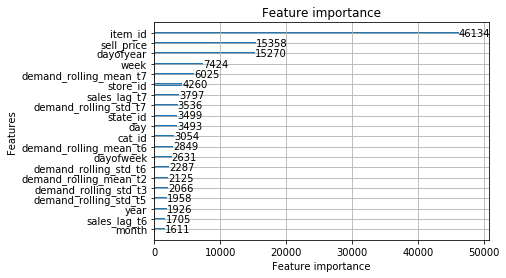

In [206]:
model = lgb.Booster(model_file = "model_12.lgb")
lgb.plot_importance(model, max_num_features = 20)

In [27]:
testing_df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,0.884079,0.810047,0.665188,0.536858,0.600088,0.608176,0.635881,0.441680,0.754566,0.849171,...,0.648355,1.000473,0.940563,0.713077,0.722681,0.755162,0.816956,0.950633,1.173078,1.068204
1,0.676351,0.643886,0.626739,0.570801,0.565174,0.558689,0.504319,0.365608,0.292932,0.287678,...,0.301704,0.350675,0.353399,0.281118,0.268107,0.340739,0.328905,0.382318,0.433263,0.430802
2,0.368973,0.340823,0.330948,0.328530,0.378835,0.479276,0.408887,0.304108,0.303706,0.286856,...,0.638779,0.882802,1.102983,0.867685,0.826818,0.822888,0.787003,0.812953,0.966192,1.008331
3,3.036799,2.312012,2.175457,2.168854,1.997716,2.361458,2.026224,1.284937,1.521321,1.465837,...,2.127772,2.402758,2.469033,1.978603,1.860428,1.778195,1.556206,2.114291,3.536713,3.493385
4,1.069282,0.757482,0.986796,1.401343,1.421766,1.455440,2.040420,1.514513,1.538276,1.429306,...,1.207285,1.523440,1.578005,1.167557,1.042056,1.059923,1.131947,1.286538,1.661443,1.938959


In [47]:
testing_df = pd.read_csv('model_43.csv')

In [48]:
testing_df = testing_df.iloc[0:30490, 1:]

In [49]:
gc.collect()

60

In [50]:
array = testing_df.values

In [51]:
array.shape

(30490, 28)

In [52]:
e.score(array)

0.4104254077137752
0.46977827582061876
0.5843113594456287
0.4535459685224453
0.5384612611685415
0.5427805281195962
0.6176765295907567
0.6506966545540969
0.7132253444531631
0.8894546697696106
0.8809289930491407
0.8625935657336907


0.6344898798284221

In [95]:
e.score(array)

0.46661361033474386
0.5312380523203603
0.6006188017491721
0.5356688264058808
0.6491392724931713
0.6130201187250267
0.7109406208485836
0.6966142602319216
0.7735763453768469
0.8536759284635929
0.8594603637440428
0.8539167853638279


0.6787069155047641

In [101]:
e.score(array)

0.31784164034088536
0.40144043884417957
0.511001302038765
0.3687788654092487
0.4697020537143225
0.477915019329517
0.5608120210600871
0.5846129824643606
0.6570342597183093
0.8787113048393893
0.8697826239966754
0.8560342006388031


0.5794722260328786

**Out of stock feature stuff, ignore for now

In [7]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, random
from tqdm import tqdm

import seaborn as sns  
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [8]:
def gap_finder(ts):
    
    #ts: 0 = day with sales, 1 = days with 0 sales
    for i, gap in enumerate(ts):
        if gap == 0: 
            continue
        elif i!=0: 
            ts[i] += ts[i-1]
            if ts[i-1]!=0: ts[i-1] = -1
    return ts

In [9]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_2_114_WI_3_validation,HOBBIES_2_114,HOBBIES_2,HOBBIES,WI_3,WI,0,train,2014-03-21,11407,NaN,NaN,NaN,NaN,0,0,0,1.969727
1,HOBBIES_2_115_WI_3_validation,HOBBIES_2_115,HOBBIES_2,HOBBIES,WI_3,WI,0,train,2014-03-21,11407,NaN,NaN,NaN,NaN,0,0,0,2.470703
2,HOBBIES_2_116_WI_3_validation,HOBBIES_2_116,HOBBIES_2,HOBBIES,WI_3,WI,0,train,2014-03-21,11407,NaN,NaN,NaN,NaN,0,0,0,2.970703
3,HOBBIES_2_117_WI_3_validation,HOBBIES_2_117,HOBBIES_2,HOBBIES,WI_3,WI,0,train,2014-03-21,11407,NaN,NaN,NaN,NaN,0,0,0,2.769531
4,HOBBIES_2_118_WI_3_validation,HOBBIES_2_118,HOBBIES_2,HOBBIES,WI_3,WI,1,train,2014-03-21,11407,NaN,NaN,NaN,NaN,0,0,0,3.970703


In [10]:
data['gaps'] = (~(data['demand'] > 0)).astype(int)
total_days = 632

prods = list(data.id.unique())
s_list = [] #list to hold gaps in days
e_list = [] #list to hold expected values of gaps
p_list = [] #list to hold avg probability of no sales


In [11]:
data = truncate(data, '2014-05-01')

In [12]:
print(data['date'].nunique())

752


In [13]:
for prod_id, df in tqdm(data.groupby("id")):   
    # extract gap_series for a prod_id
    sales_gaps = df.loc[:,'gaps']

    # calculate initial probability
    zero_days = sum(sales_gaps)
    p = zero_days/total_days

    # find and mark gaps
    accum_add_prod = np.frompyfunc(lambda x, y: int((x+y)*y), 2, 1)
    sales_gaps[:] = accum_add_prod.accumulate(df["gaps"], dtype=np.object).astype(int)
    sales_gaps[sales_gaps < sales_gaps.shift(-1)] = np.NaN
    sales_gaps = sales_gaps.fillna(method="bfill").fillna(method='ffill')
    s_list += [sales_gaps]

del sales_gaps
gc.collect()

100%|██████████| 30490/30490 [02:58<00:00, 170.39it/s]


0

In [14]:
data['gap_days'] = pd.concat(s_list)

In [15]:
del s_list
gc.collect()

40

In [56]:
data = truncate(data, '06-01-14')

In [16]:
data['gap_confirm'] = data['gaps'] * data['gap_days']

In [17]:
del data['gap_days']
gc.collect()

40

In [18]:
def out_of_stock(data):
    out_of_stock = []
    sales_dict = {}
    for prod_id, df in tqdm(data.groupby("id")):   
        # extract gap_series for a prod_id
        sales_gaps = df.loc[:,'gap_confirm']
        avg_sales = float(df.loc[:, 'demand'].mean())
        if (avg_sales != 0):
            threshold = 1/(avg_sales) * 20
        else:
            threshold = 1000
              
        sales_dict[prod_id] = avg_sales
        out_of_stock += [sales_gaps.where(sales_gaps < threshold, np.NaN)]
    
    data['out_of_stock'] = pd.concat(out_of_stock)
    return data, sales_dict
      

In [19]:
data, avg_sales = out_of_stock(data)

100%|██████████| 30490/30490 [01:24<00:00, 361.70it/s] 


In [20]:
data = reduce_mem_usage(data)

Mem. usage decreased to 2580.22 Mb (17.5% reduction)


In [21]:
del avg_sales
gc.collect()

40

In [22]:
data['true'] = data['out_of_stock'].isna()

In [23]:
gc.collect()
data = data.reset_index()

In [24]:
data['imputed_demand'] = data['demand']

rows = data[data.true == True].index
for row in rows:
    data['imputed_demand'].iloc[row] = data['demand'].iloc[row - (7 * 30490)]

In [25]:
data = reduce_mem_usage(data)
gc.collect()

Mem. usage decreased to 2558.36 Mb (3.3% reduction)


20

In [147]:
for col in data.columns:
    print(col)

id
item_id
dept_id
cat_id
store_id
state_id
demand
part
date
wm_yr_wk
event_name_1
event_type_1
event_name_2
event_type_2
snap_CA
snap_TX
snap_WI
sell_price
year
month
quarter
week
day
dayofweek
dayofyear
imputed_price
scaled_weight
date_time
totalSnow_cm
uvIndex
FeelsLikeC
HeatIndexC
WindChillC
WindGustKmph
cloudcover
humidity
precipMM
pressure
population
lag_0
lag_1
lag_7
lag_28
shift_1_rolling_mean_7
shift_1_rolling_std_7
shift_1_rolling_mean_14
shift_1_rolling_std_14
shift_1_rolling_mean_28
shift_1_rolling_std_28
shift_7_rolling_std_7
shift_7_rolling_std_14
shift_7_rolling_std_28
shift_7_rolling_mean_7
shift_7_rolling_mean_14
shift_7_rolling_mean_28
lag_3


In [27]:
print(data.dtypes)

date                       object
revenue                   float64
demand                      int64
id                         object
item_id                     int64
dept_id                     int64
cat_id                      int64
store_id                    int64
state_id                    int64
event_name_1                int64
event_type_1                int64
event_name_2                int64
event_type_2                int64
snap_CA                     int64
snap_TX                     int64
snap_WI                     int64
sell_price                float64
year                        int64
month                       int64
quarter                     int64
week                        int64
day                         int64
dayofweek                   int64
dayofyear                   int64
demand_rolling_mean_t1    float64
demand_rolling_std_t1     float64
sales_lag_t1              float64
demand_rolling_mean_t2    float64
demand_rolling_std_t2     float64
sales_lag_t2  

In [ ]:
data = reduce_mem_usage(data)

In [ ]:
gc.collect()

In [55]:
data['scaled_weight'].head()

0    0.000051
1    0.000003
2    0.000014
3    0.000024
4    0.000018
Name: scaled_weight, dtype: float16

In [40]:
for col in data.columns:
    print(col)

id
item_id
dept_id
cat_id
store_id
state_id
demand
part
date
wm_yr_wk
event_name_1
event_type_1
event_name_2
event_type_2
snap_CA
snap_TX
snap_WI
sell_price
year
month
quarter
week
day
dayofweek
dayofyear
imputed_price
date_time
totalSnow_cm
uvIndex
FeelsLikeC
HeatIndexC
WindChillC
WindGustKmph
cloudcover
humidity
precipMM
pressure
population


In [15]:
del data['new_weights']

In [16]:
del data['daily_scales']

In [62]:
def unmelt(data):
    rect = data.pivot(index = 'id', columns = 'date', values = 'demand')
    return rect
rect = unmelt(data)

def add_lags(grid_df, shift):
    
    lags = [0, 1, 2, 3, 4, 5, 6, 28]
    start_time = time()
    print( 72 * '#', '\nAdding lag columns')
    for i in lags:
        grid_df[f'lag_{i}'] = grid_df['demand'].shift(30490 * (i + shift)).astype(np.float16)
    
    print(f'Time: {(time() - start_time):.2f} seconds')
        
        
############################################################       
################# Rolling window columns ###################

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)



def make_rolling_col(rw, window, function, weights = False): 
    # We need to take off the last columns to
    # get the rolling feature shifted one day.
    
    split_rw = np.split(rw, 10, axis=0)
    split_col = [function(rw, -1) for rw in split_rw]
    col = np.concatenate(split_col)
    col = col[:, :-1].T.reshape(-1,)

    # The new column must be prepended with np.nans 
    # to account for missing gaps
    
    
    weight_7 = [1, 1, 1, 1, 1, 1, 4]
    weight_14 = [1, 1, 1, 1, 1, 1, 2.5, 1, 1, 1, 1, 1, 1, 4]
    weight_28 = [1, 1, 1, 1, 1, 1, 1.5, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2.5, 1, 1, 1, 1, 1, 1, 4]
    if (weights == True):
        if (window == 7):
            split_rw = np.split(rw, 10, axis=0)
            split_col = [function(rw, -1, weights = weight_7) for rw in split_rw]
            col = np.concatenate(split_col)
            col = col[:, :-1].T.reshape(-1,)
        elif (window == 14):
            split_rw = np.split(rw, 10, axis=0)
            split_col = [function(rw, -1, weights = weight_14) for rw in split_rw]
            col = np.concatenate(split_col)
            col = col[:, :-1].T.reshape(-1,)
        else:
            split_rw = np.split(rw, 10, axis=0)
            split_col = [function(rw, -1, weights = weight_28) for rw in split_rw]
            col = np.concatenate(split_col)
            col = col[:, :-1].T.reshape(-1,)
            
            
    return np.append(np.zeros(30490 * window) + np.nan, col).astype(np.float16)

    




def add_rolling_cols(df: pd.DataFrame, rec: np.array, windows: list, weighted_windows, functions: list, function_names: list): 
    """Adds rolling features to df."""
    
    print( 72 * '#', '\nAdding rolling columns\n',  )
    start_time = time()
    f = list(zip(functions, function_names))
    
    for window in windows: 
        rw = rolling_window(rec, window)
        for function in f: 
            s_time = time()
            if (function[1] != 'weighted_mean'):
                df[f'shift_1_rolling_{function[1]}_{str(window)}'] = make_rolling_col(rw, window, function[0])
                print(f'{function[1]} with window {window} time: {(time() - s_time):.2f} seconds')
    
    for window in weighted_windows: 
        rw = rolling_window(rec, window)
        for function in f: 
            s_time = time()
            if (function[1] == 'weighted_mean'):
                df[f'shift_1_rolling_{function[1]}_{str(window)}'] = make_rolling_col(rw, window, function[0], weights = True)
                print(f'{function[1]} with window {window} time: {(time() - s_time):.2f} seconds')
                
                
    print(f'Total time for rolling cols: {(time() - start_time)/60:.2f}')
    
    
    
############################################################       
################# Shifting function ########################
def add_shift_cols(grid_df, shifts, cols, num_series=30490): 
    
    print( 72 * '#', '\nAdding shift columns',  )
    start_time = time()
    for shift in shifts: 
        for col in cols: 
            grid_df[f"{col.replace('shift_1', f'shift_{shift}')}"] = grid_df[col].shift((shift - 1) * num_series)
    print(f'Time: {(time() - start_time):.2f} seconds')


         
            
############################################################       
################# Create lags df ###########################
def make_lags_df_1(data, rec): 
    
    start_time = time()

    window = 7
    add_lags(data, window)
    add_rolling_cols(data, 
                     rec, 
                     windows=[7, 14, 28], 
                     functions=[np.mean, np.std, np.average], 
                     function_names=['mean', 'std', 'weighted_mean'])
    
    shifts = [7]
    cols = [f'shift_1_rolling_std_{i}' for i in [7, 14, 28]]
    add_shift_cols(data, shifts, cols, num_series=30490)
    ocols = [f'shift_1_rolling_mean_{i}' for i in [7, 14, 28]]
    add_shift_cols(data, shifts, ocols, num_series=30490)
    oocols = [f'shift_1_rolling_weighted_mean_{i}' for i in [7, 14, 28]]
    add_shift_cols(data, shifts, oocols, num_series=30490)
    
    
    print(72 * '#', f'Total time: {(time() - start_time)//60:} : {(time() - start_time)%60:.2f}')
    return data

def make_lags_df_2(data, rec): 
    
    start_time = time()
    
    window = 14
    add_lags(data, window)
    add_rolling_cols(data, 
                     rec, 
                     windows=[7, 14, 28], 
                     functions=[np.mean, np.std, np.average], 
                     function_names=['mean', 'std', 'weighted_mean'])
    
    
    shifts = [14]
    cols = [f'shift_1_rolling_std_{i}' for i in [7, 14, 28]]
    add_shift_cols(data, shifts, cols, num_series=30490)
    ocols = [f'shift_1_rolling_mean_{i}' for i in [7, 14, 28]]
    add_shift_cols(data, shifts, ocols, num_series=30490)
    oocols = [f'shift_1_rolling_weighted_mean_{i}' for i in [7, 14, 28]]
    add_shift_cols(data, shifts, oocols, num_series=30490)
    
    print(72 * '#', f'Total time: {(time() - start_time)//60:} : {(time() - start_time)%60:.2f}')
    return data

def make_lags_df_3(data, rec): 
    
    start_time = time()

    window = 21
    add_lags(data, window)
    add_rolling_cols(data, 
                     rec, 
                     windows=[7, 14, 28], 
                     functions=[np.mean, np.std, np.average], 
                     function_names=['mean', 'std', 'weighted_mean'])
    
    
    shifts = [21]
    cols = [f'shift_1_rolling_std_{i}' for i in [7, 14, 28]]
    add_shift_cols(data, shifts, cols, num_series=30490)
    ocols = [f'shift_1_rolling_mean_{i}' for i in [7, 14, 28]]
    add_shift_cols(data, shifts, ocols, num_series=30490)
    oocols = [f'shift_1_rolling_weighted_mean_{i}' for i in [7, 14, 28]]
    add_shift_cols(data, shifts, oocols, num_series=30490)
    
    print(72 * '#', f'Total time: {(time() - start_time)//60:} : {(time() - start_time)%60:.2f}')
    return data

def make_lags_df_4(data, rec): 
    
    start_time = time()

    
    window = 28
    add_lags(data, window)
    add_rolling_cols(data, 
                     rec, 
                     windows=[7, 14, 28],
                     weighted_windows = [7, 14, 28], 
                     functions=[np.mean, np.std, np.average], 
                     function_names=['mean', 'std', 'weighted_mean'])
    
    
    shifts = [28]
    cols = [f'shift_1_rolling_std_{i}' for i in [7, 14, 28]]
    add_shift_cols(data, shifts, cols, num_series=30490)
    ocols = [f'shift_1_rolling_mean_{i}' for i in [7, 14, 28]]
    add_shift_cols(data, shifts, ocols, num_series=30490)
    oocols = [f'shift_1_rolling_weighted_mean_{i}' for i in [7, 14, 28]]
    add_shift_cols(data, shifts, oocols, num_series=30490)
    
    print(72 * '#', f'Total time: {(time() - start_time)//60:} : {(time() - start_time)%60:.2f}')
    return data

In [97]:
arr = [[14, 17, 12, 33, 44],   
       [15, 6, 27, 8, 19],  
       [23, 2, 54, 1, 4, ]]  

print(np.average(arr, -1, weights =  [1, 2, 3, 1, 1]))

[20.125 16.875 24.25 ]


In [112]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,...,shift_1_rolling_weighted_mean_14,shift_1_rolling_mean_28,shift_1_rolling_std_28,shift_1_rolling_weighted_mean_28,shift_28_rolling_std_7,shift_28_rolling_std_14,shift_28_rolling_std_28,shift_28_rolling_mean_7,shift_28_rolling_mean_14,shift_28_rolling_mean_28
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-04-02,11409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,train,2014-04-02,11409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,train,2014-04-02,11409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,0,train,2014-04-02,11409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,2,train,2014-04-02,11409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data = transform(data)
gc.collect()

from time import time 

rec = unmelt(data)
rec = rec.values
data = make_lags_df(data, rec)
data = truncate(data, '2014-07-01')
data = reduce_mem_usage(data)
gc.collect()

Mem. usage decreased to 1427.82 Mb (54.7% reduction)
######################################################################## 
Adding lag columns
Time: 2.57 seconds
######################################################################## 
Adding rolling columns

mean with window 7 time: 1.74 seconds
std with window 7 time: 3.35 seconds
mean with window 14 time: 1.84 seconds
std with window 14 time: 5.34 seconds
mean with window 28 time: 2.10 seconds
std with window 28 time: 8.36 seconds
Total time for rolling cols: 0.38
######################################################################## 
Adding shift columns
Time: 0.16 seconds
######################################################################## 
Adding shift columns
Time: 0.18 seconds
######################################################################## Total time: 0.0 : 25.65
Mem. usage decreased to 1928.89 Mb (0.0% reduction)


0

In [25]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,...,shift_1_rolling_mean_14,shift_1_rolling_std_14,shift_1_rolling_mean_28,shift_1_rolling_std_28,shift_28_rolling_std_7,shift_28_rolling_std_14,shift_28_rolling_std_28,shift_28_rolling_mean_7,shift_28_rolling_mean_14,shift_28_rolling_mean_28
3112500,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-07-02,11422,...,0.785645,0.673828,0.893066,0.938965,1.641602,1.288086,1.166992,1.142578,0.643066,0.821289
3112501,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,train,2014-07-02,11422,...,0.714355,0.795410,0.750000,1.089844,4.558594,3.507812,2.677734,3.285156,2.214844,1.571289
3112502,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,train,2014-07-02,11422,...,0.000000,0.000000,0.035706,0.185547,0.000000,0.772461,0.600586,0.000000,0.214233,0.178589
3112503,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1,train,2014-07-02,11422,...,0.285645,0.588867,0.250000,0.508789,0.451660,0.410400,0.410400,0.285645,0.214233,0.214233
3112504,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,0,train,2014-07-02,11422,...,0.500000,1.118164,0.392822,0.899902,1.049805,0.903320,0.905762,0.571289,0.428467,0.464355


In [28]:
del temp_data
gc.collect()

40

In [13]:
id_list = data['id'].unique()
num_days = data['date'].nunique()
merger = []
for id_name in id_list:
    for i in range(num_days):
        merger.append(id_name)

In [14]:
data = reduce_mem_usage(data)
data = data.sort_values(by = merger)
data.head()

Mem. usage decreased to 2652.00 Mb (6.5% reduction)


KeyError: 'HOBBIES_2_114_WI_3_validation'

In [16]:
num_days = data['date'].nunique()

index_list = []
for i in range(30490):
        index = i
        index_list.append(i)
        for j in range(num_days - 1):
            index += (30490)
            index_list.append(index)
            

In [15]:
data = truncate(data, '2014-04-01')

In [16]:
data = data.reset_index()
gc.collect()

40

In [103]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,...,uvIndex,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,population
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-04-02,11409,...,1,4,8,4,29,10,49,0.199951,1014,27511000.0
1,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-04-03,11409,...,1,9,10,9,19,25,39,0.000000,1018,27511476.0
2,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-04-04,11409,...,1,10,12,10,22,22,32,0.000000,1013,27511950.0
3,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-04-05,11410,...,1,8,10,8,26,3,49,0.000000,1015,27512424.0
4,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2014-04-06,11410,...,1,14,15,14,11,1,29,0.000000,1019,27512900.0


In [17]:
print(len(index_list))

23843180


In [19]:
print(index_list[-1])

23843179


In [46]:
data.tail()

,index,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
23843175,24181085,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,2.980469
23843176,24181086,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,2.480469
23843177,24181087,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,3.980469
23843178,24181088,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,1.280273
23843179,24181089,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,1.000000


In [20]:
data = data.reindex(index_list)

In [21]:
data = data.reset_index()
gc.collect()

120

In [24]:
del data['level_0']
data = transform(data)


Mem. usage decreased to 1955.52 Mb (32.3% reduction)


In [26]:
data['sell_price'] = data['sell_price'].astype('float32')
data = impute_price(data)

Mem. usage decreased to 272.86 Mb (25.0% reduction)


In [17]:
wdf = pd.read_csv('weight_scale_1914.csv')

In [18]:
level12 = wdf[wdf.Level_id == 'Level12']

In [19]:
del wdf
gc.collect()

60

In [20]:
level12.head()

,Unnamed: 0,Level_id,Agg_Level_1,Agg_Level_2,weight,scale
12350,12350,Level12,FOODS_1_001,CA_1,1.972157e-05,2.922071
12351,12351,Level12,FOODS_1_001,CA_2,1.852632e-05,5.740586
12352,12352,Level12,FOODS_1_001,CA_3,1.434296e-05,10.198222
12353,12353,Level12,FOODS_1_001,CA_4,5.378610e-06,1.019362
12354,12354,Level12,FOODS_1_001,TX_1,5.976234e-07,3.461538


In [30]:
def byLevelWRMSSE(y_pred, y_true, level):
    y_true = y_true.get_label()
    diff = (y_true - y_pred).astype("float").reshape((30490, 28))
    diff_squared = np.square(m5.transformer[level](diff))
    return "Lev {}".format(level), np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[level] / 12.0), False

In [31]:
minWeight = min([i for i in m5.weights[12] if i != 0])
maximum = m5.weights[12].max()
def level12Weighted(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    for i in range(30490): 
        residual[i * num_days:(i+1) * num_days] = max(minWeight, m5.weights[12][i]) / maximum * residual[i * num_days:(i+1) * num_days]
    grad = -20.0 * residual
    hess = 20.0 * np.ones(residual.shape)
    return grad, hess

In [ ]:
def groupByDay(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    grad = np.zeros(y_pred.shape)
    hess = np.zeros(y_pred.shape)
    for i in range(num_days):
        all_series = residual[range(i, total, num_days)]
        grad[range(i, total, num_days)] -= all_series.sum() / (30490 * 2.0)
    return grad, hess

In [ ]:
def combined1(y_pred, y_true):
    l12grad, l12hess = level12Weighted(y_pred, y_true)
    groupgrad, grouphess = groupByDay(y_pred, y_true)
    return l12grad + groupgrad, l12hess + grouphess

In [ ]:
def level1Weight(y_pred, y_true, weight = weight, scale = scale):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    num_days = int(len(y_pred) / 30490)
    res_1 = []
    for i in len(num_days):
        tempsum = 0
        tracker = 0
        index_list = [i] 
        index = i
        while (tracker < 30490):
            tracker += 1
            tempsum += residual[i]
            index += num_days
            index_list.append[index]
            
        for index in index_list:
            residual[index] = tempsum * weight / np.sqrt(scale)
        
    

In [10]:
data = truncate(data, '2014-03-22')

In [11]:
gc.collect()

20

In [12]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
33010,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2014-03-23,11408,NaN,NaN,NaN,NaN,0,0,0,8.257812
33011,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2014-03-23,11408,NaN,NaN,NaN,NaN,0,0,0,3.970703
33012,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2014-03-23,11408,NaN,NaN,NaN,NaN,0,0,0,2.970703
33013,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,2,train,2014-03-23,11408,NaN,NaN,NaN,NaN,0,0,0,4.640625
33014,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,train,2014-03-23,11408,NaN,NaN,NaN,NaN,0,0,0,3.080078


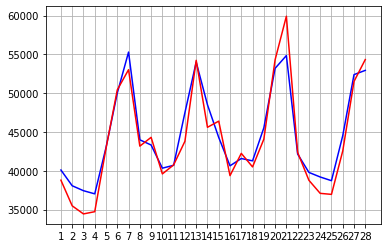

In [15]:
level = 12
plt.plot(range(1,29), [np.sum(m5.transformer[level](array), axis = 0)[day] for day in range(28)], 'b')
plt.plot(range(1,29), [np.sum(m5.transformer[level](m5.actuals), axis = 0)[day] for day in range(28)], 'r')
plt.xticks(range(1,29))
plt.grid(True)
plt.show()

In [13]:
testing_df = pd.read_csv('model_39.csv')

In [14]:
array = testing_df.iloc[0:30490, 1:].values